In [345]:
SHARED="/data/sharing/QuakeCoRE"

import sys
sys.path.append(f"{SHARED}/qcore")
sys.path.append(f"{SHARED}/Vs30")

import numpy as np
import os.path
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

from qcore import geo
from vs30 import model, model_geology,sites_cluster

geo_ids={#0: ("G00","Water"),
         1: ("G01","Peat"),
         2: ("G04","Artificial fill"),
         3: ("G05","Fluvial and esturarine deposits"),
         4: ("G06","Alluvium and valley sediments"),
         5: ("G08","Lacustrine"),
         6: ("G09", "Beach, bar, dune deposits"),
         7: ("G10", "Fan deposits"),
         8: ("G11", "Loess"),
         9: ("G12", "Glacigenic sediments"),
         10: ("G13", "Flood deposits"),
         11: ("G14", "Glacial moraines and till"),
         12: ("G15", "Undifferentiated sediments and sedimentary rocks"),
         13: ("G16", "Terrace deposits and old alluvium"),
         14: ("G17", "Volcanic rocks and deposits"),
         15: ("G18", "Crystalline rocks"),
        }


HOME = Path(os.path.expanduser("~"))
outdir = HOME /"Data/cpt/outdir"
vs30_results=outdir / "vs30_results.csv"
assert vs30_results.exists()
vs30_df=pd.read_csv(vs30_results,index_col=0)
points=vs30_df[['NZTM_X','NZTM_Y']].values



def __padding(n):
    if n==3:
        return [8,5,2]
    elif n==4:
        return [8,6,4,2]
    

def plot_vs30_for_all_geo_ids(data_dict):
    #data_dict = {legend : [means,error,marker,colour],...}
    
    geo_id_codes= [x for x,_ in geo_ids.values()] # (G01, G04 ....)

    fig,ax=plt.subplots()
    ax.set_xlabel("Geology Categories")
    ax.set_ylabel("Vs30 (m/s)")
    #ax.yaxis.grid(True)

    ax.set_yscale('log')
    ax.set_ylim([100,2000])
    yticks=[100,200,300,400,500,600,800,1000,2000]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

    #customizing xtick labels
    geo_id_values = np.array([(i)*10 for i in range(len(geo_ids))]) 
    ax.set_xticks(geo_id_values)
    ax.set_xticklabels(geo_id_codes,fontdict={'horizontalalignment':'right'})

    error_bars =[]
    padding = __padding(len(data_dict))
    
    for i,key in enumerate(data_dict.keys()):
        error_bars.append(ax.errorbar(geo_id_values-padding[i],data_dict[key][0], data_dict[key][1],linestyle="None",marker=data_dict[key][2],color=data_dict[key][3]))
    

    ax.grid()

    ax.legend(error_bars,data_dict.keys(),loc=2)


    plt.tight_layout()
    plt.show()

def dist_x_range(mean,std,n_bins):
    return np.linspace(mean-3*std,mean+3*std,n_bins)


def __plot_hist_dist(vs30_data,n_bins,data_dict,id):

    plt.rcParams['figure.figsize'] = [8, 5]


    fig,ax=plt.subplots()
    ax.set_xlabel("Vs30 (m/s)")
    ax.set_ylabel("Probability")

    new_p=ax.hist(vs30_data,bins=n_bins, density=True,color="blue",label="Data(McGann15 rel)")
    
    gid,description = geo_ids[id]

    for i,key in enumerate(data_dict.keys()):
        mean,error,color=data_dict[key]
        x=dist_x_range(mean[id-1],error[id-1],n_bins)
        ax.plot(x,stats.norm.pdf(x,mean[id-1],error[id-1]),color=color,label=key)
    
    ax.legend(loc=2)
    ax.set_title("{}: {}".format(gid,description))
    
    plt.show()
    fig.savefig(outdir/'{}.png'.format(gid))    

def plot_hist_dist(data_dict,id):
    

    __plot_hist_dist(vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==id].Vs30, 50, data_dict,id)
    


For a given location, we can get a model_id like this

In [346]:
print(model_geology.model_id(np.array([[1759275.267087352],[5903767.814975549]]).T))

/data/sharing/QuakeCoRE/Vs30/vs30/data/qmap/qmap.shp
[12]


In [347]:
vs30_df

NZTM_X        NZTM_Y         Vsz        Vs30  Zmax  Zmin  \
CPT_1         1.576467e+06  5.181262e+06  171.591623  184.625369    25  0.04   
CPT_10001     1.570257e+06  5.178666e+06         NaN         NaN    23  0.00   
CPT_10002     1.571352e+06  5.180853e+06  148.562114  180.154681    19  0.06   
CPT_10003     1.571621e+06  5.179830e+06         NaN         NaN    27  0.00   
CPT_10004     1.571595e+06  5.179847e+06         NaN         NaN    27  0.00   
...                    ...           ...         ...         ...   ...   ...   
SCPT_TT95420  1.746165e+06  5.969918e+06   76.587603  142.757404     8  0.01   
SCPT_TT98489  1.746126e+06  5.969925e+06   85.323869  148.349113     9  0.01   
SCPT_TT98490  1.746165e+06  5.969916e+06   76.867446  143.296270     8  0.01   
SCPT_TT98757  1.746599e+06  5.967065e+06  105.964657  132.779118    17  0.01   
SCPT_TT98758  1.746201e+06  5.967078e+06   96.012311  123.179367    16  0.08   

              Zspan  
CPT_1         25.92  
CPT_10001     23.34  
CPT_10002     19.86  
CPT_10003     27.30  
CPT_10004     27.24  
...             ...  
SCPT_TT95420   8.32  
SCPT_TT98489   9.18  
SCPT_TT98490   8.24  
SCPT_TT98757  17.70  
SCPT_TT98758  16.56  

[28906 rows x 7 columns]

The following works out model_ids for all locations. Can take some time. If the CSV file exists, it will just load the file instead.

In [348]:
model_ids_csv_file=Path(f"{SHARED}/Data/model_ids.csv")

if model_ids_csv_file.exists():
    model_ids=np.loadtxt(model_ids_csv_file)
else:
    model_ids=model_geology.model_id(points)
    np.savetxt(model_ids_csv_file,model_ids)



## Combine Vs30 estimates with Geological category ID
Add model_ids to vs30_df, and remove records whose id == 255 (meaning no data. 204 such records found) and id == 0 (Water)

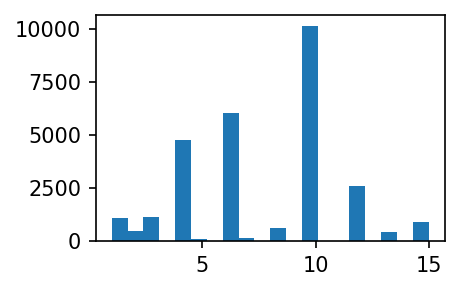

In [349]:
plt.rcParams['figure.dpi']=150
plt.rcParams["figure.figsize"] = (3,2)

vs30_geo_id_df=vs30_df.copy() 
vs30_geo_id_df['geo_model_idx']=model_ids
vs30_geo_id_df=vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']!=255] #remove 255 = ID_NODATA
vs30_geo_id_df=vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']!=0] #remove 0 = Water

plt.hist(vs30_geo_id_df.geo_model_idx,bins=20)

plt.show()

### Summaries for each category

In [350]:
# for i,(gid,geo_name) in geo_ids.items():
#     print(gid, geo_name)
#     print(vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==i].describe())

## Means and Errors for each category

In [351]:
means = []
errors = []
for i,(gid,geo_name) in geo_ids.items():
    print(gid, geo_name)
    count = vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==i].Vs30.count()
    vs30_mean= vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==i].Vs30.mean()
    vs30_std = vs30_geo_id_df.loc[vs30_geo_id_df['geo_model_idx']==i].Vs30.std()
    print("n = {} vs30={} std= {}".format(count, vs30_mean, vs30_std))

    means.append(vs30_mean)
    errors.append(vs30_std)



G01 Peat
n = 1031 vs30=171.4576885459413 std= 29.11177017207477
G04 Artificial fill
n = 448 vs30=166.7695006455548 std= 31.171725992725847
G05 Fluvial and esturarine deposits
n = 1057 vs30=172.8675985628091 std= 31.495178166710105
G06 Alluvium and valley sediments
n = 4498 vs30=169.44222339834397 std= 30.609070671806183
G08 Lacustrine
n = 99 vs30=173.67028019141534 std= 27.808683476836723
G09 Beach, bar, dune deposits
n = 5579 vs30=170.1847725855267 std= 29.084785763030403
G10 Fan deposits
n = 162 vs30=171.34851986196543 std= 27.637173425777757
G11 Loess
n = 575 vs30=165.56209832231534 std= 27.55660711666571
G12 Glacigenic sediments
n = 4 vs30=171.88343983342074 std= 36.237406571374905
G13 Flood deposits
n = 9327 vs30=170.77399628353513 std= 29.288895633779333
G14 Glacial moraines and till
n = 11 vs30=150.2845620487543 std= 35.35953839777117
G15 Undifferentiated sediments and sedimentary rocks
n = 2440 vs30=168.82512889876506 std= 29.31385040820888
G16 Terrace deposits and old alluvium

### Get prior model and posterior models

In [352]:
prior=model_geology.model_prior()
prior_means=prior.T[0]
prior_errors=prior.T[1]*prior_means

posterior = model_geology.model_posterior_paper()
posterior_means = posterior.T[0]
posterior_errors = posterior.T[1]*posterior_means

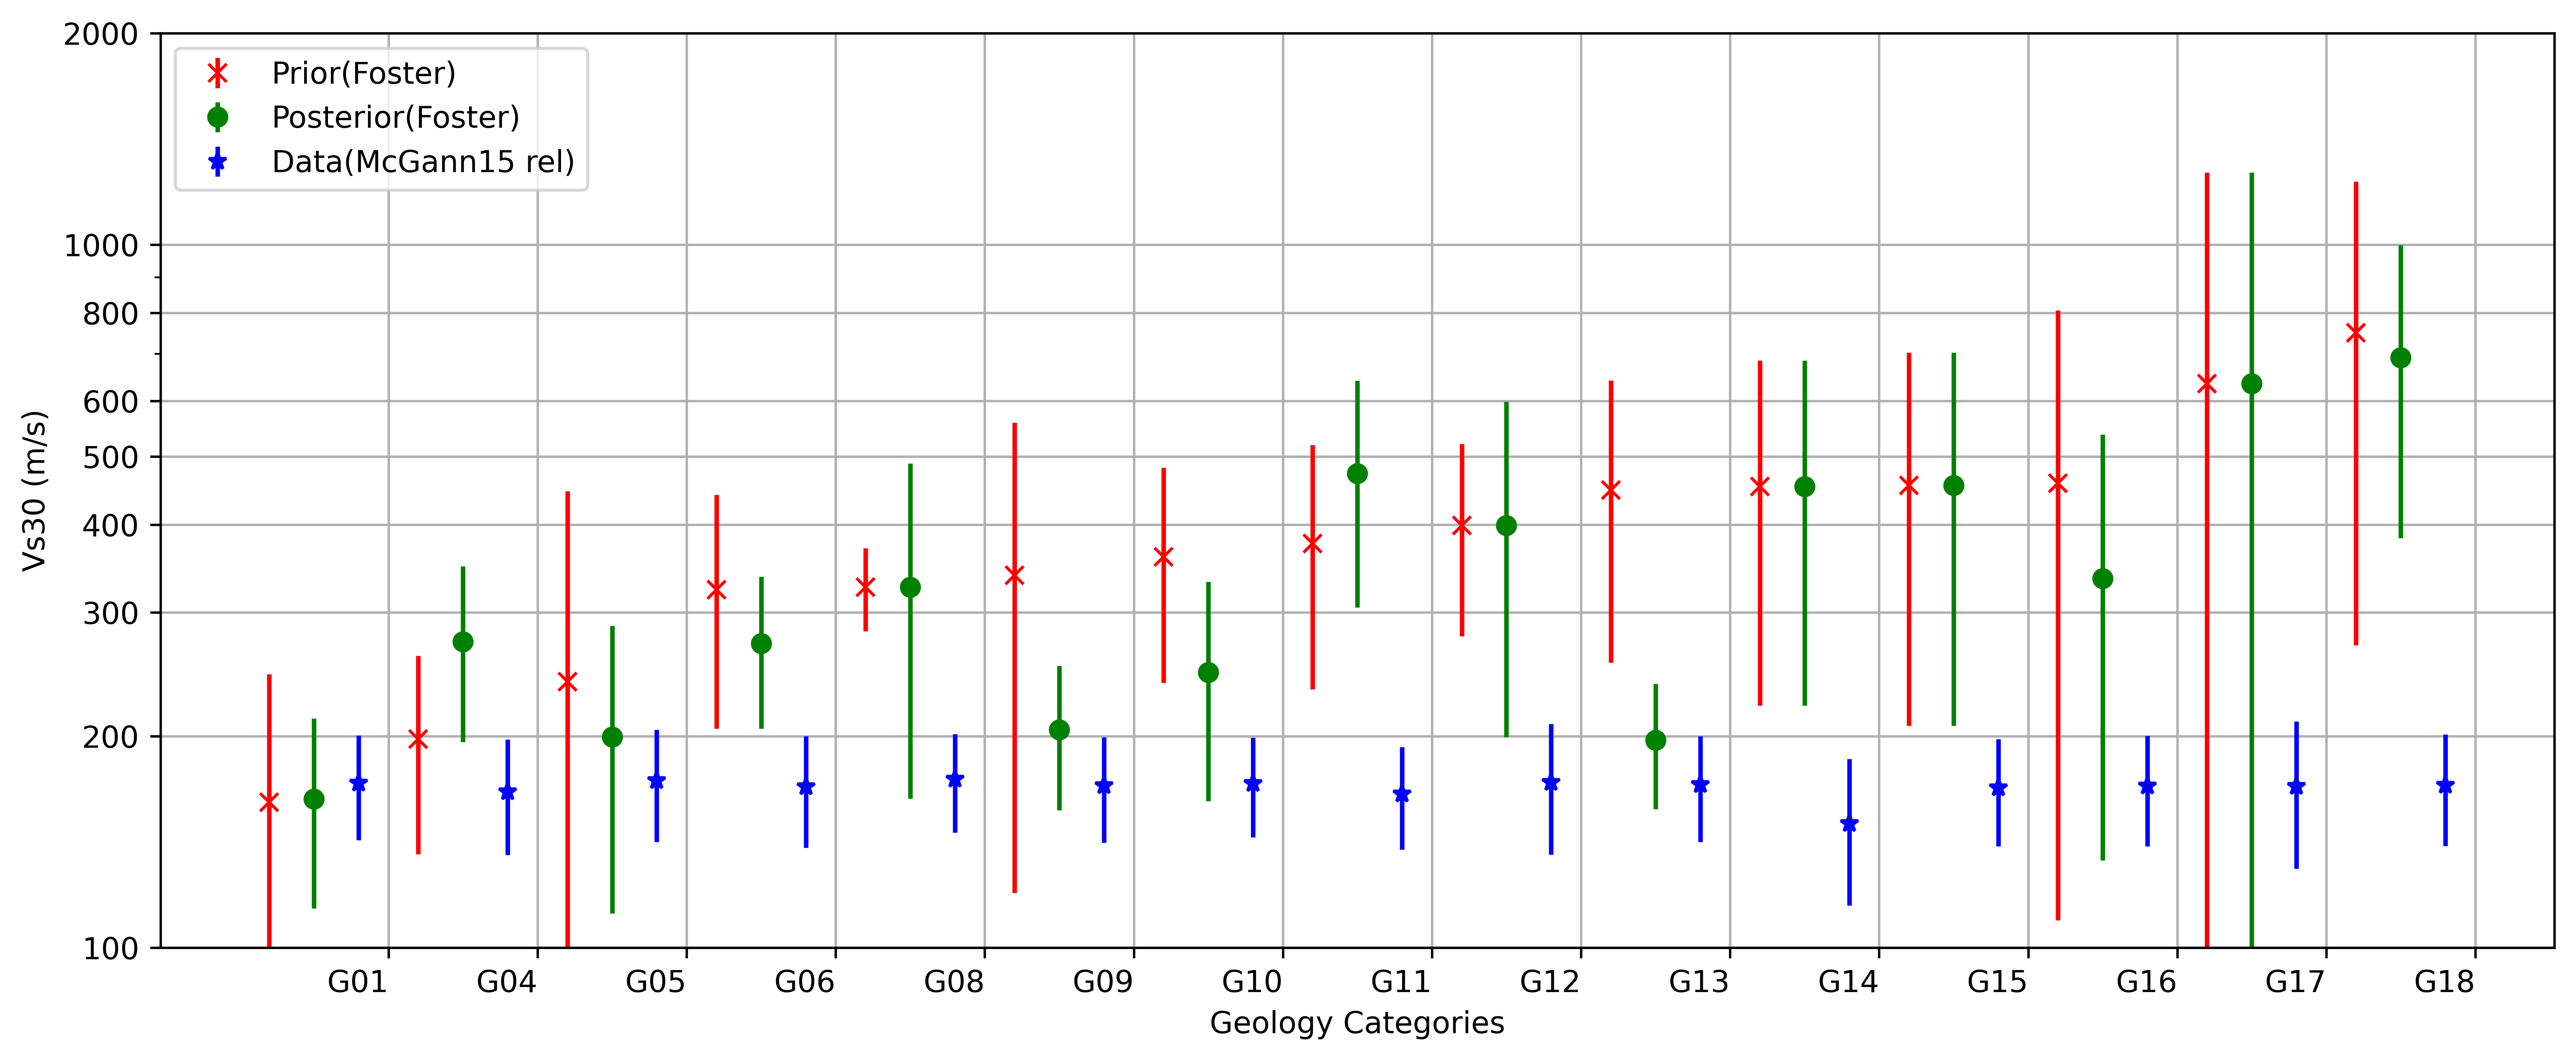

In [353]:
plt.rcParams['figure.dpi']=600
plt.rcParams["figure.figsize"] = (12,5)

data_dict = {
    "Prior(Foster)": [prior_means,prior_errors,'x','red'],
    "Posterior(Foster)": [posterior_means,posterior_errors,'o','green'],
    "Data(McGann15 rel)": [means,errors,"*","blue"]
}
plot_vs30_for_all_geo_ids(data_dict)

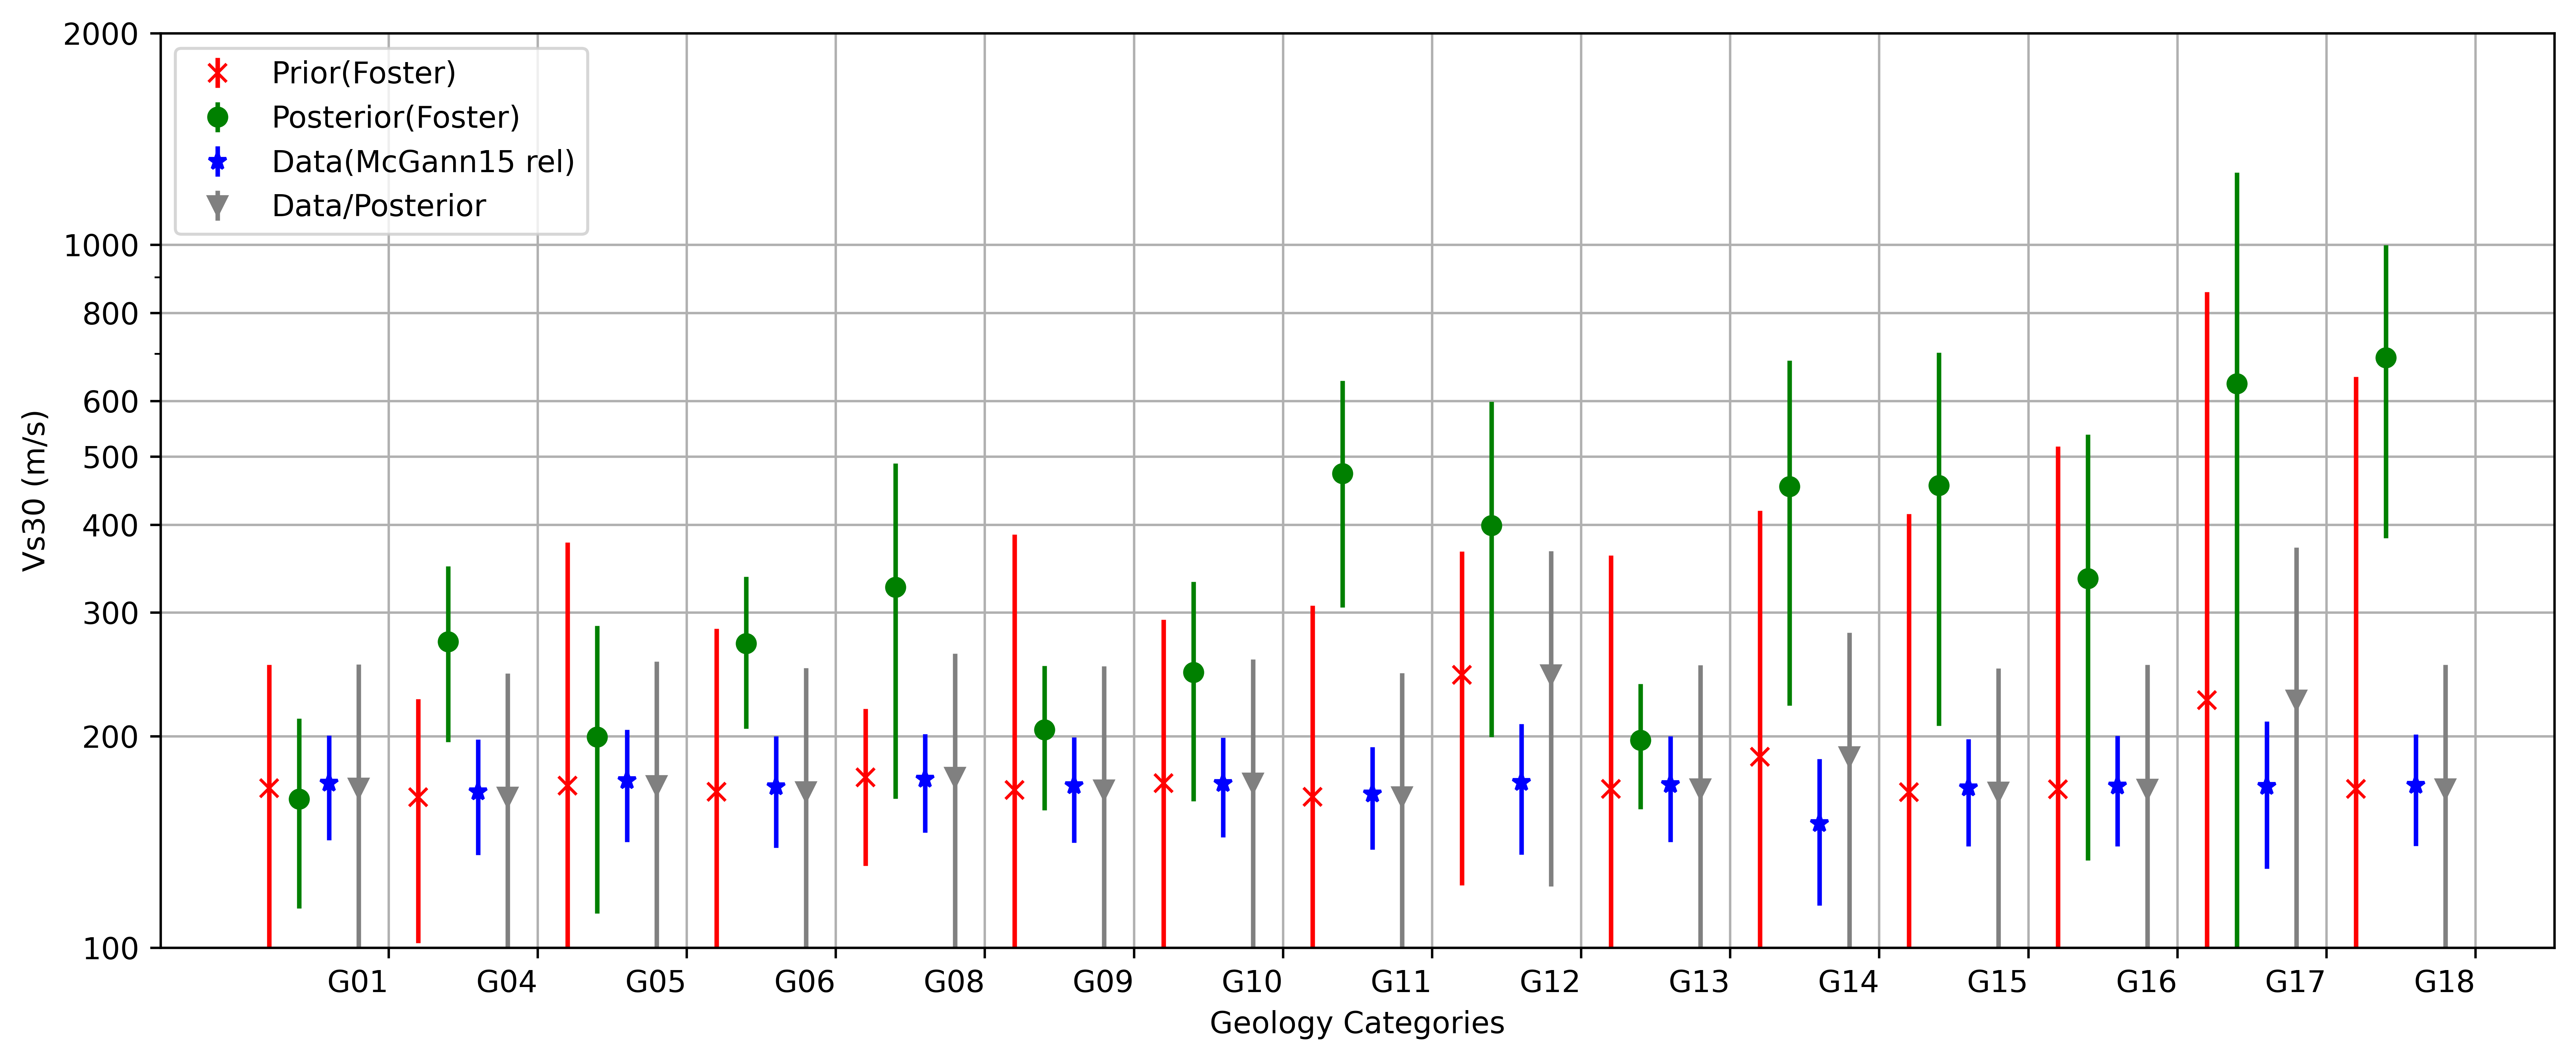

In [354]:


vs30_from_CPT=vs30_geo_id_df[['NZTM_X','NZTM_Y','Vs30','geo_model_idx']]
sites=vs30_from_CPT.loc[~np.isnan(np.float64(vs30_from_CPT['Vs30']))]
sites=sites.rename(columns={"NZTM_X":"easting","NZTM_Y":"northing","Vs30":"vs30"})
sites['gid']=np.array([x-1 for x in sites['geo_model_idx']]) #geo id is 1 greater than index in prior
sites['uncertainty']=0.5
sites
new_posterior=model.posterior(prior,sites,"gid")
new_posterior_means=new_posterior.T[0]
new_posterior_errors=new_posterior.T[1]*new_posterior_means

data_dict = {
    "Prior(Foster)": [prior_means,prior_errors,'x','red'],
    "Posterior(Foster)": [posterior_means,posterior_errors,'o','green'],
    "Data(McGann15 rel)": [means,errors,"*","blue"],
    "Data/Posterior": [new_posterior_means,new_posterior_errors,"v","grey"],
    
}
plot_vs30_for_all_geo_ids(data_dict)

In [355]:
plt.rcParams['figure.dpi']=600
plt.rcParams["figure.figsize"] = (6,3)



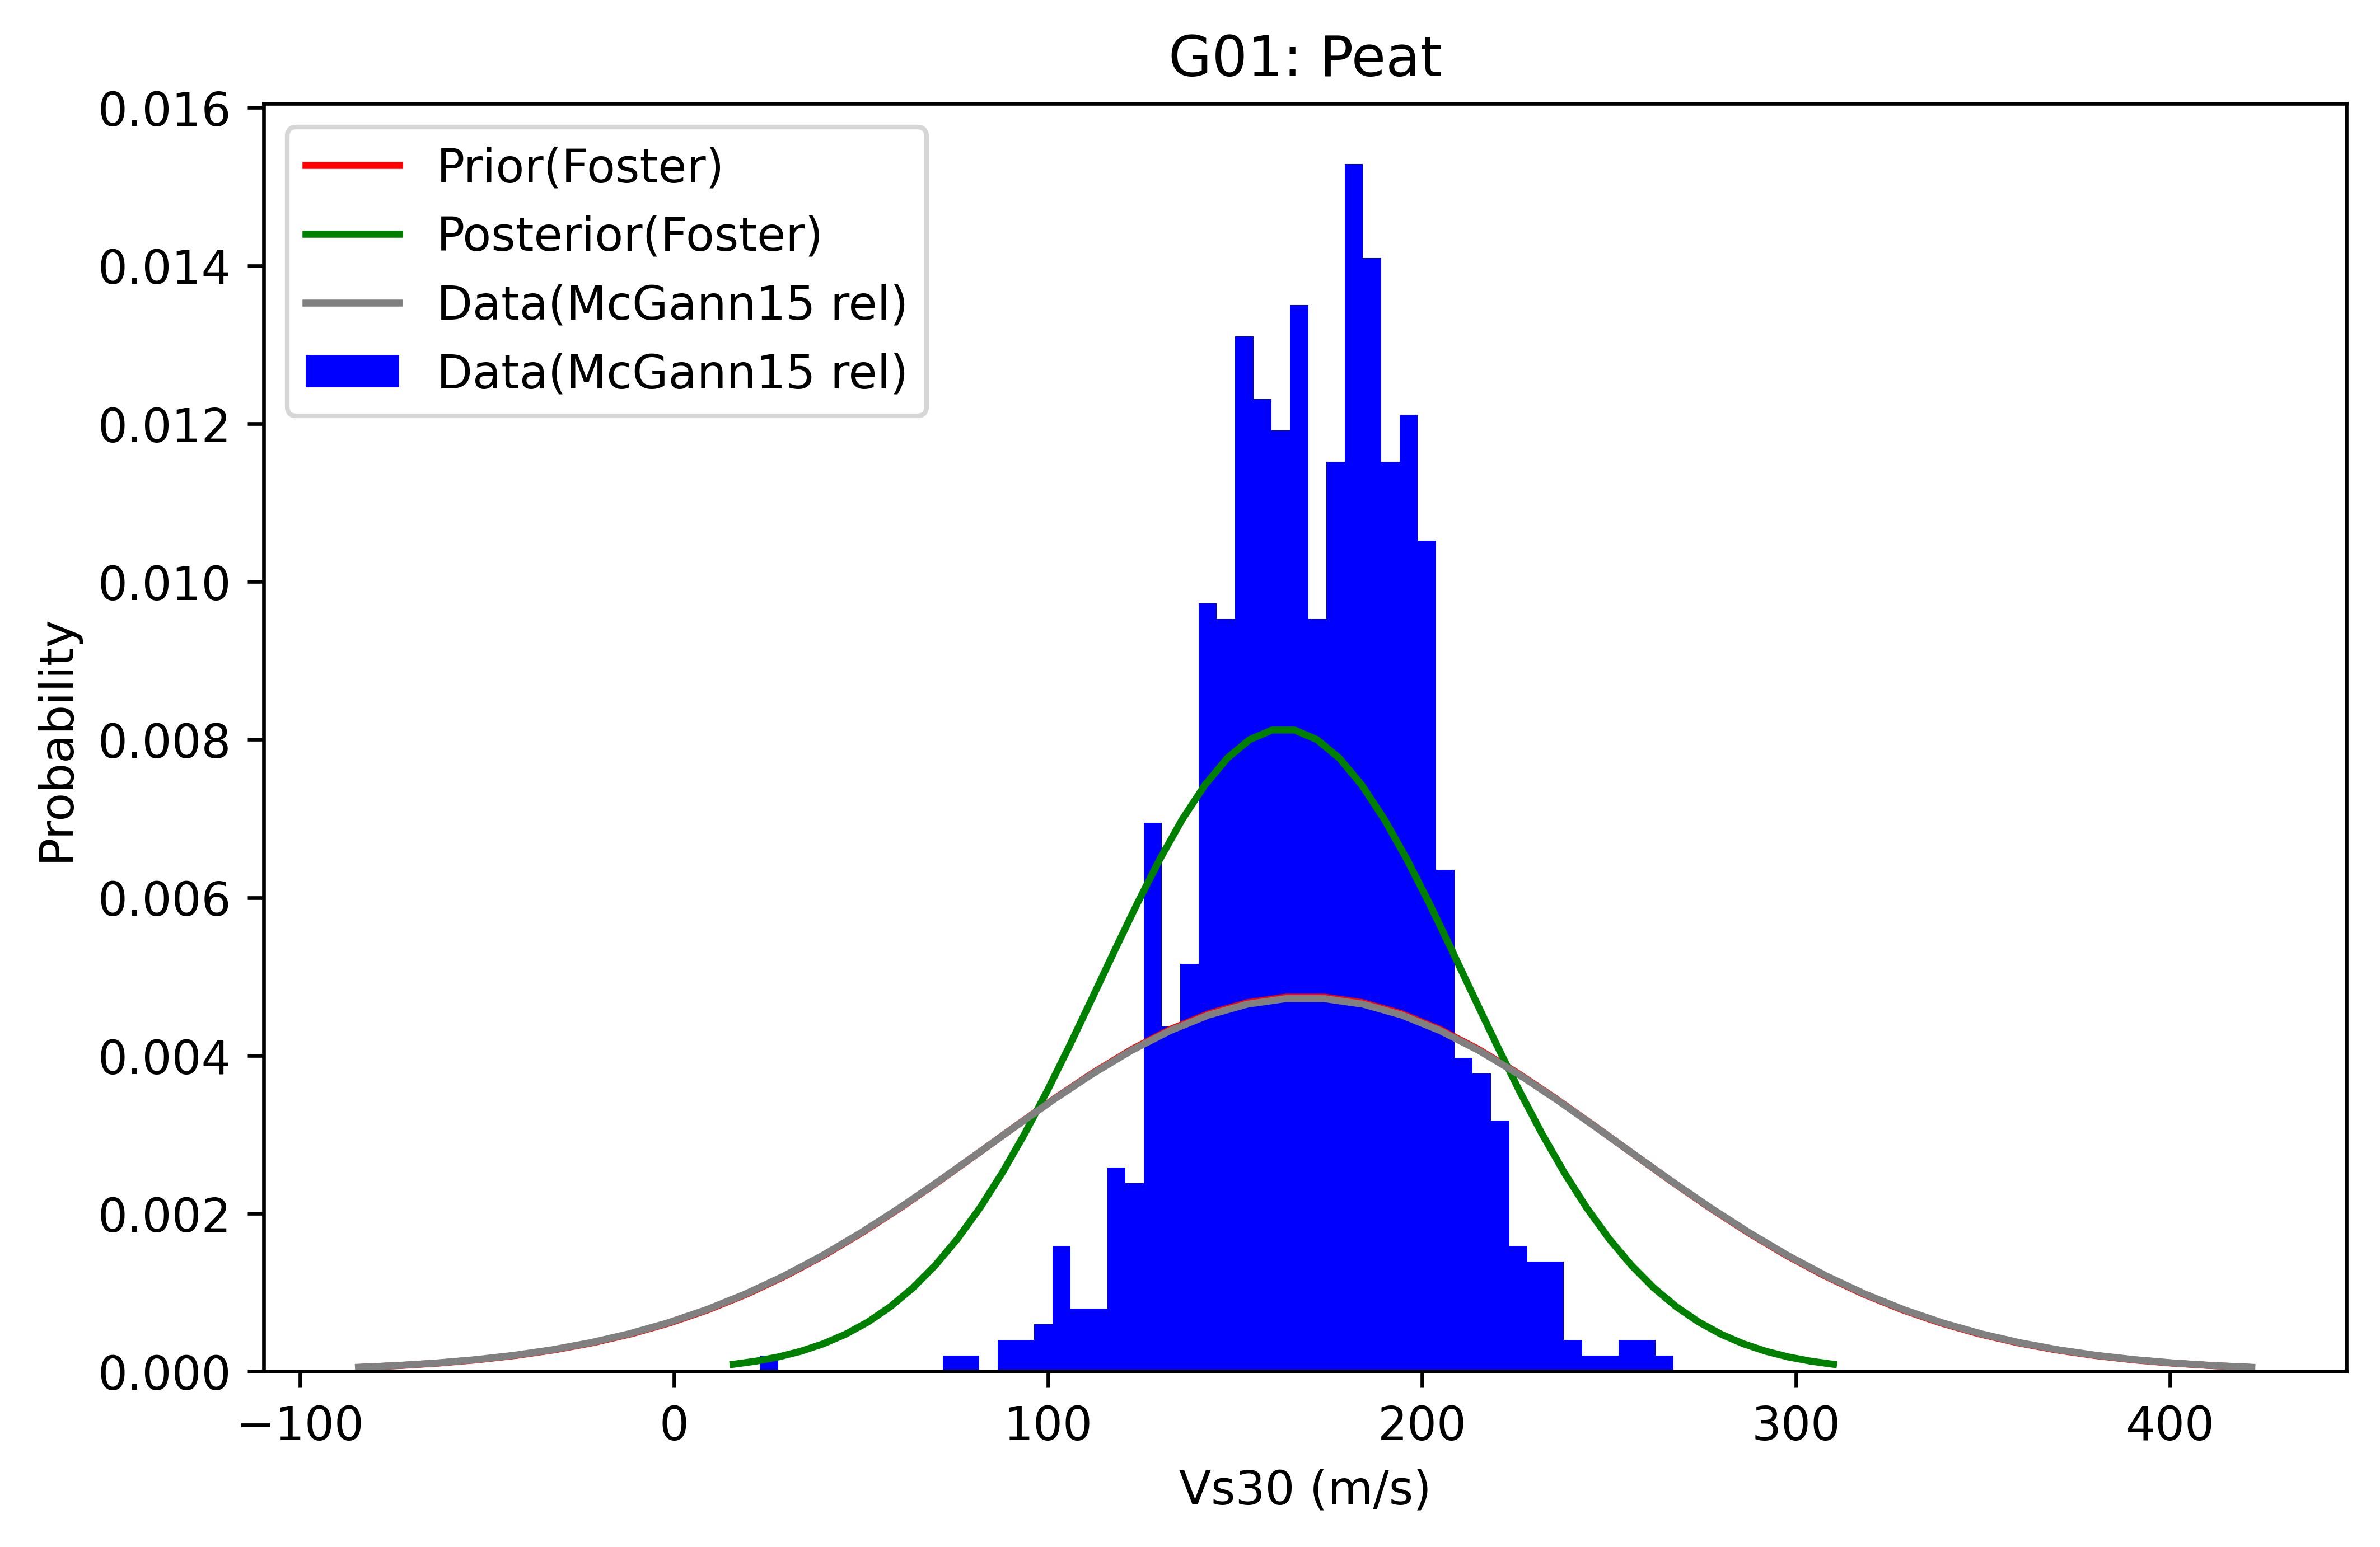

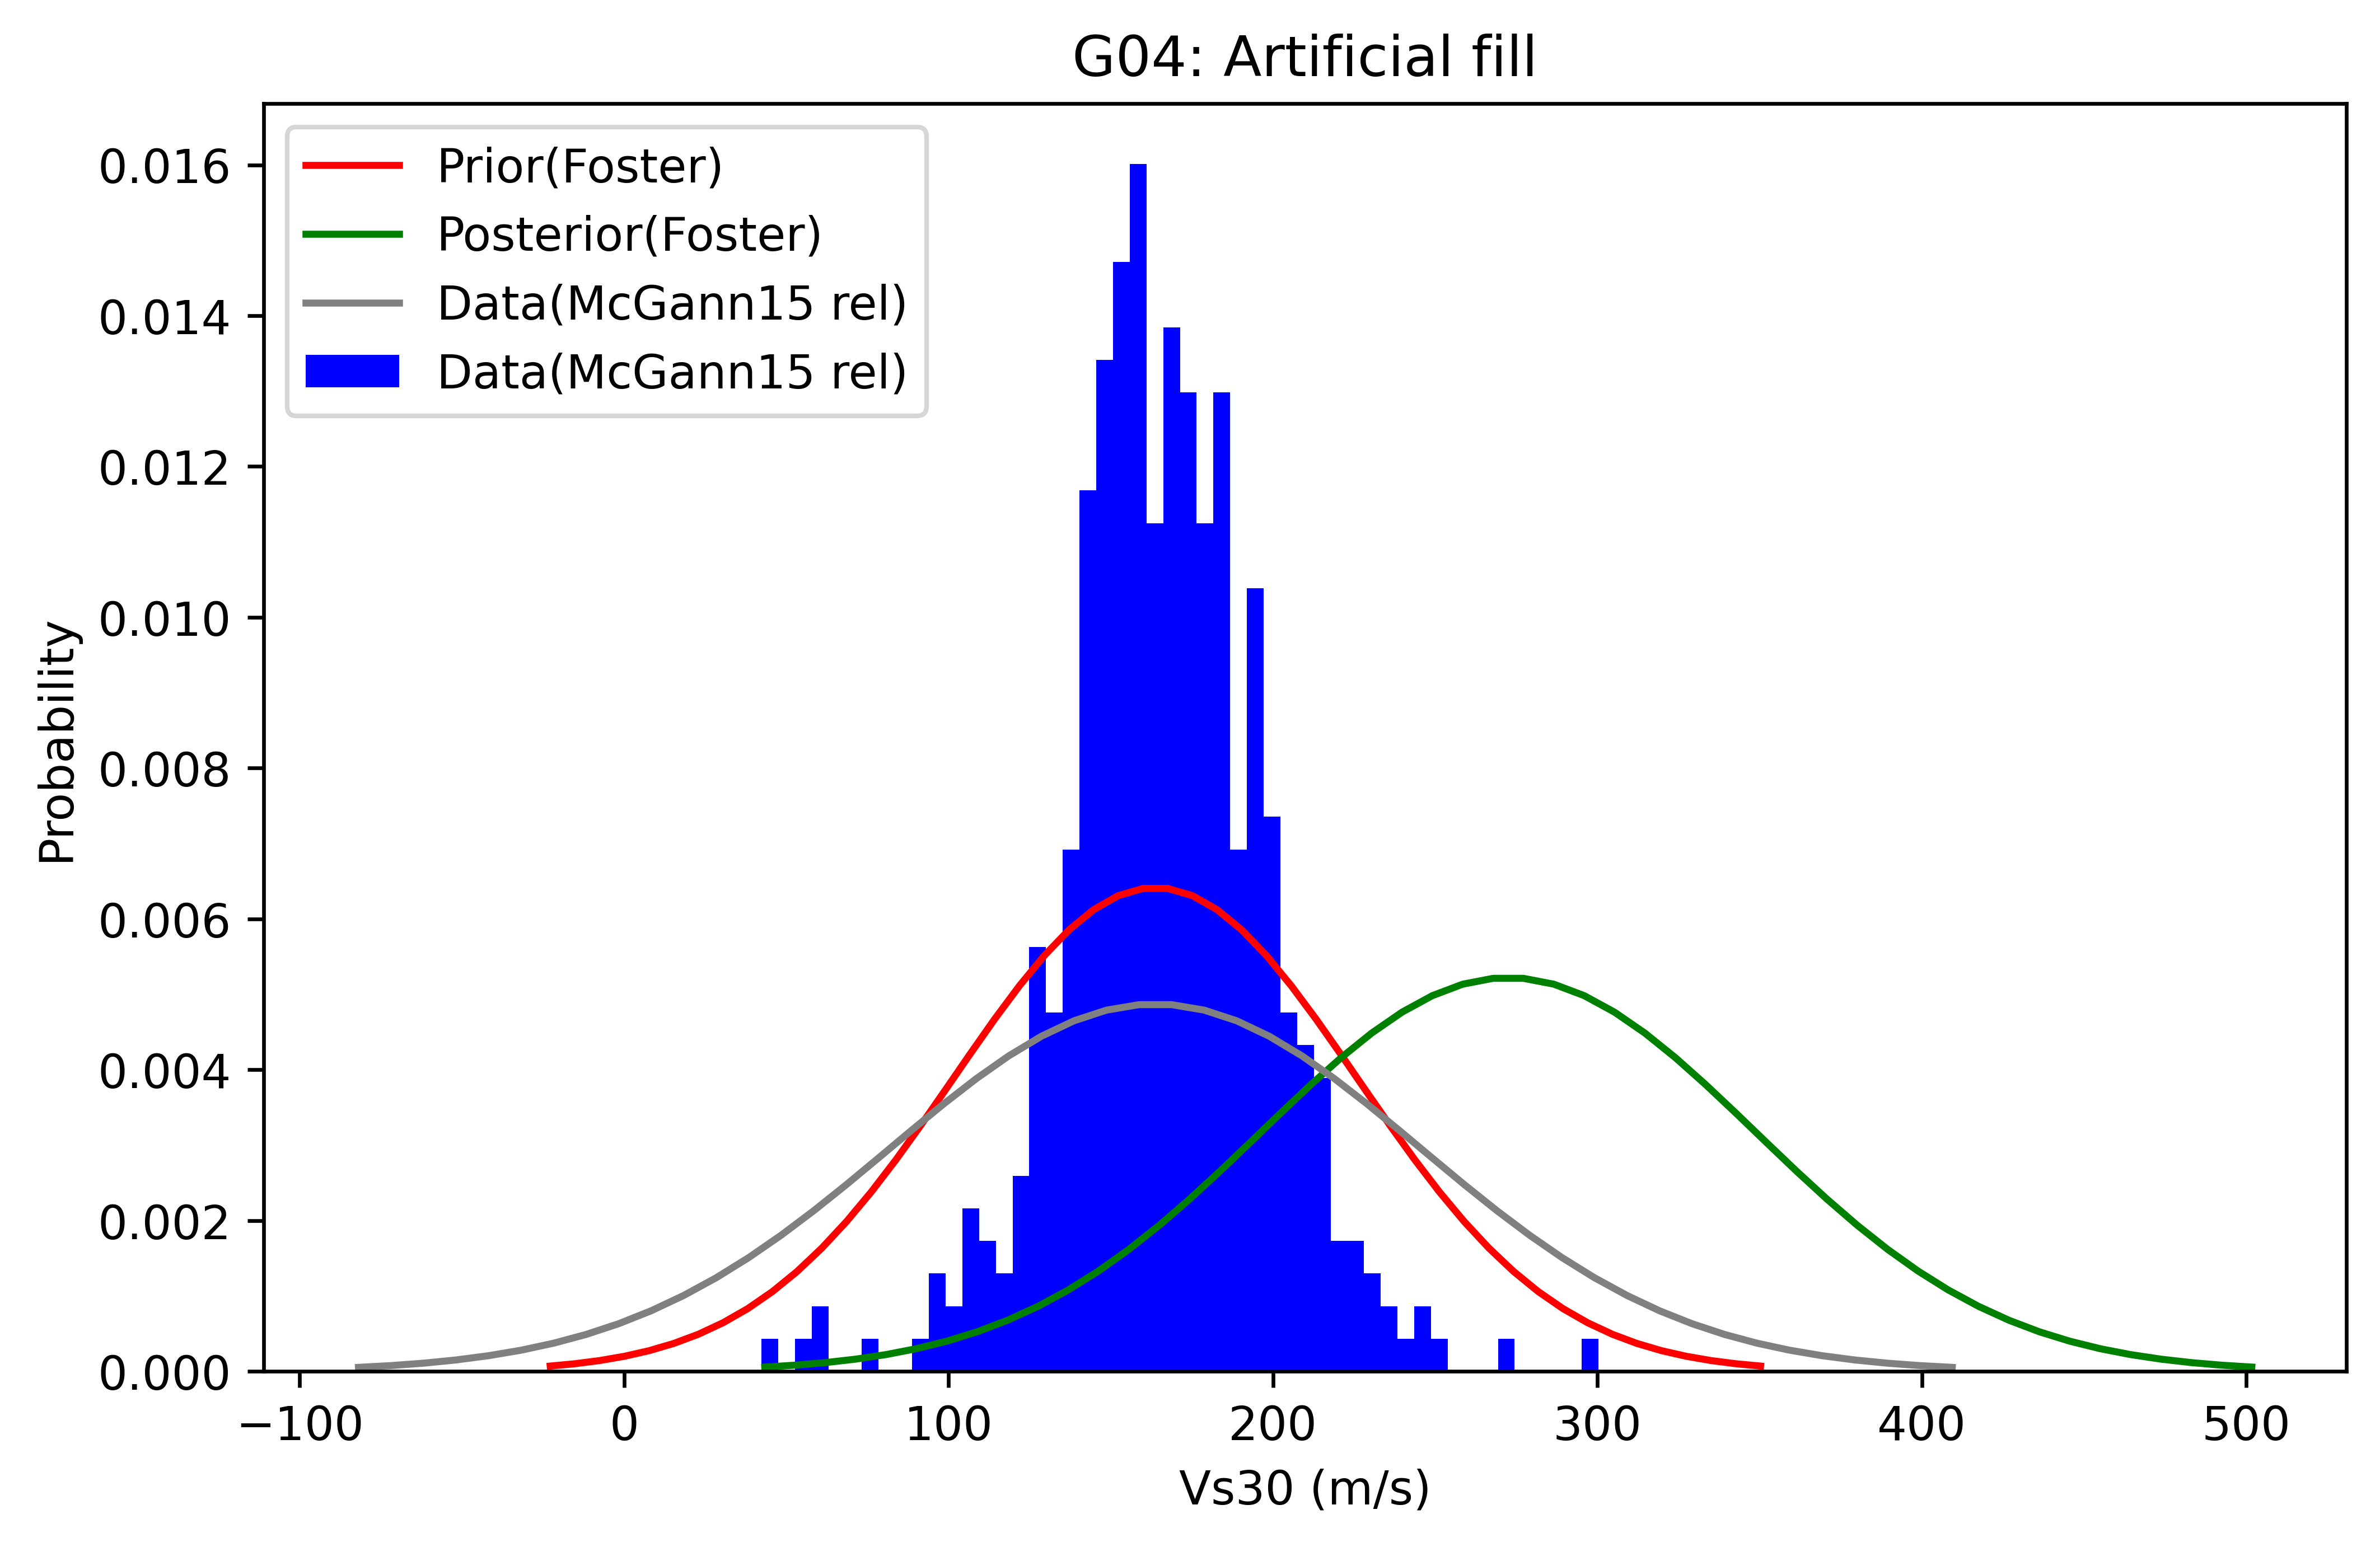

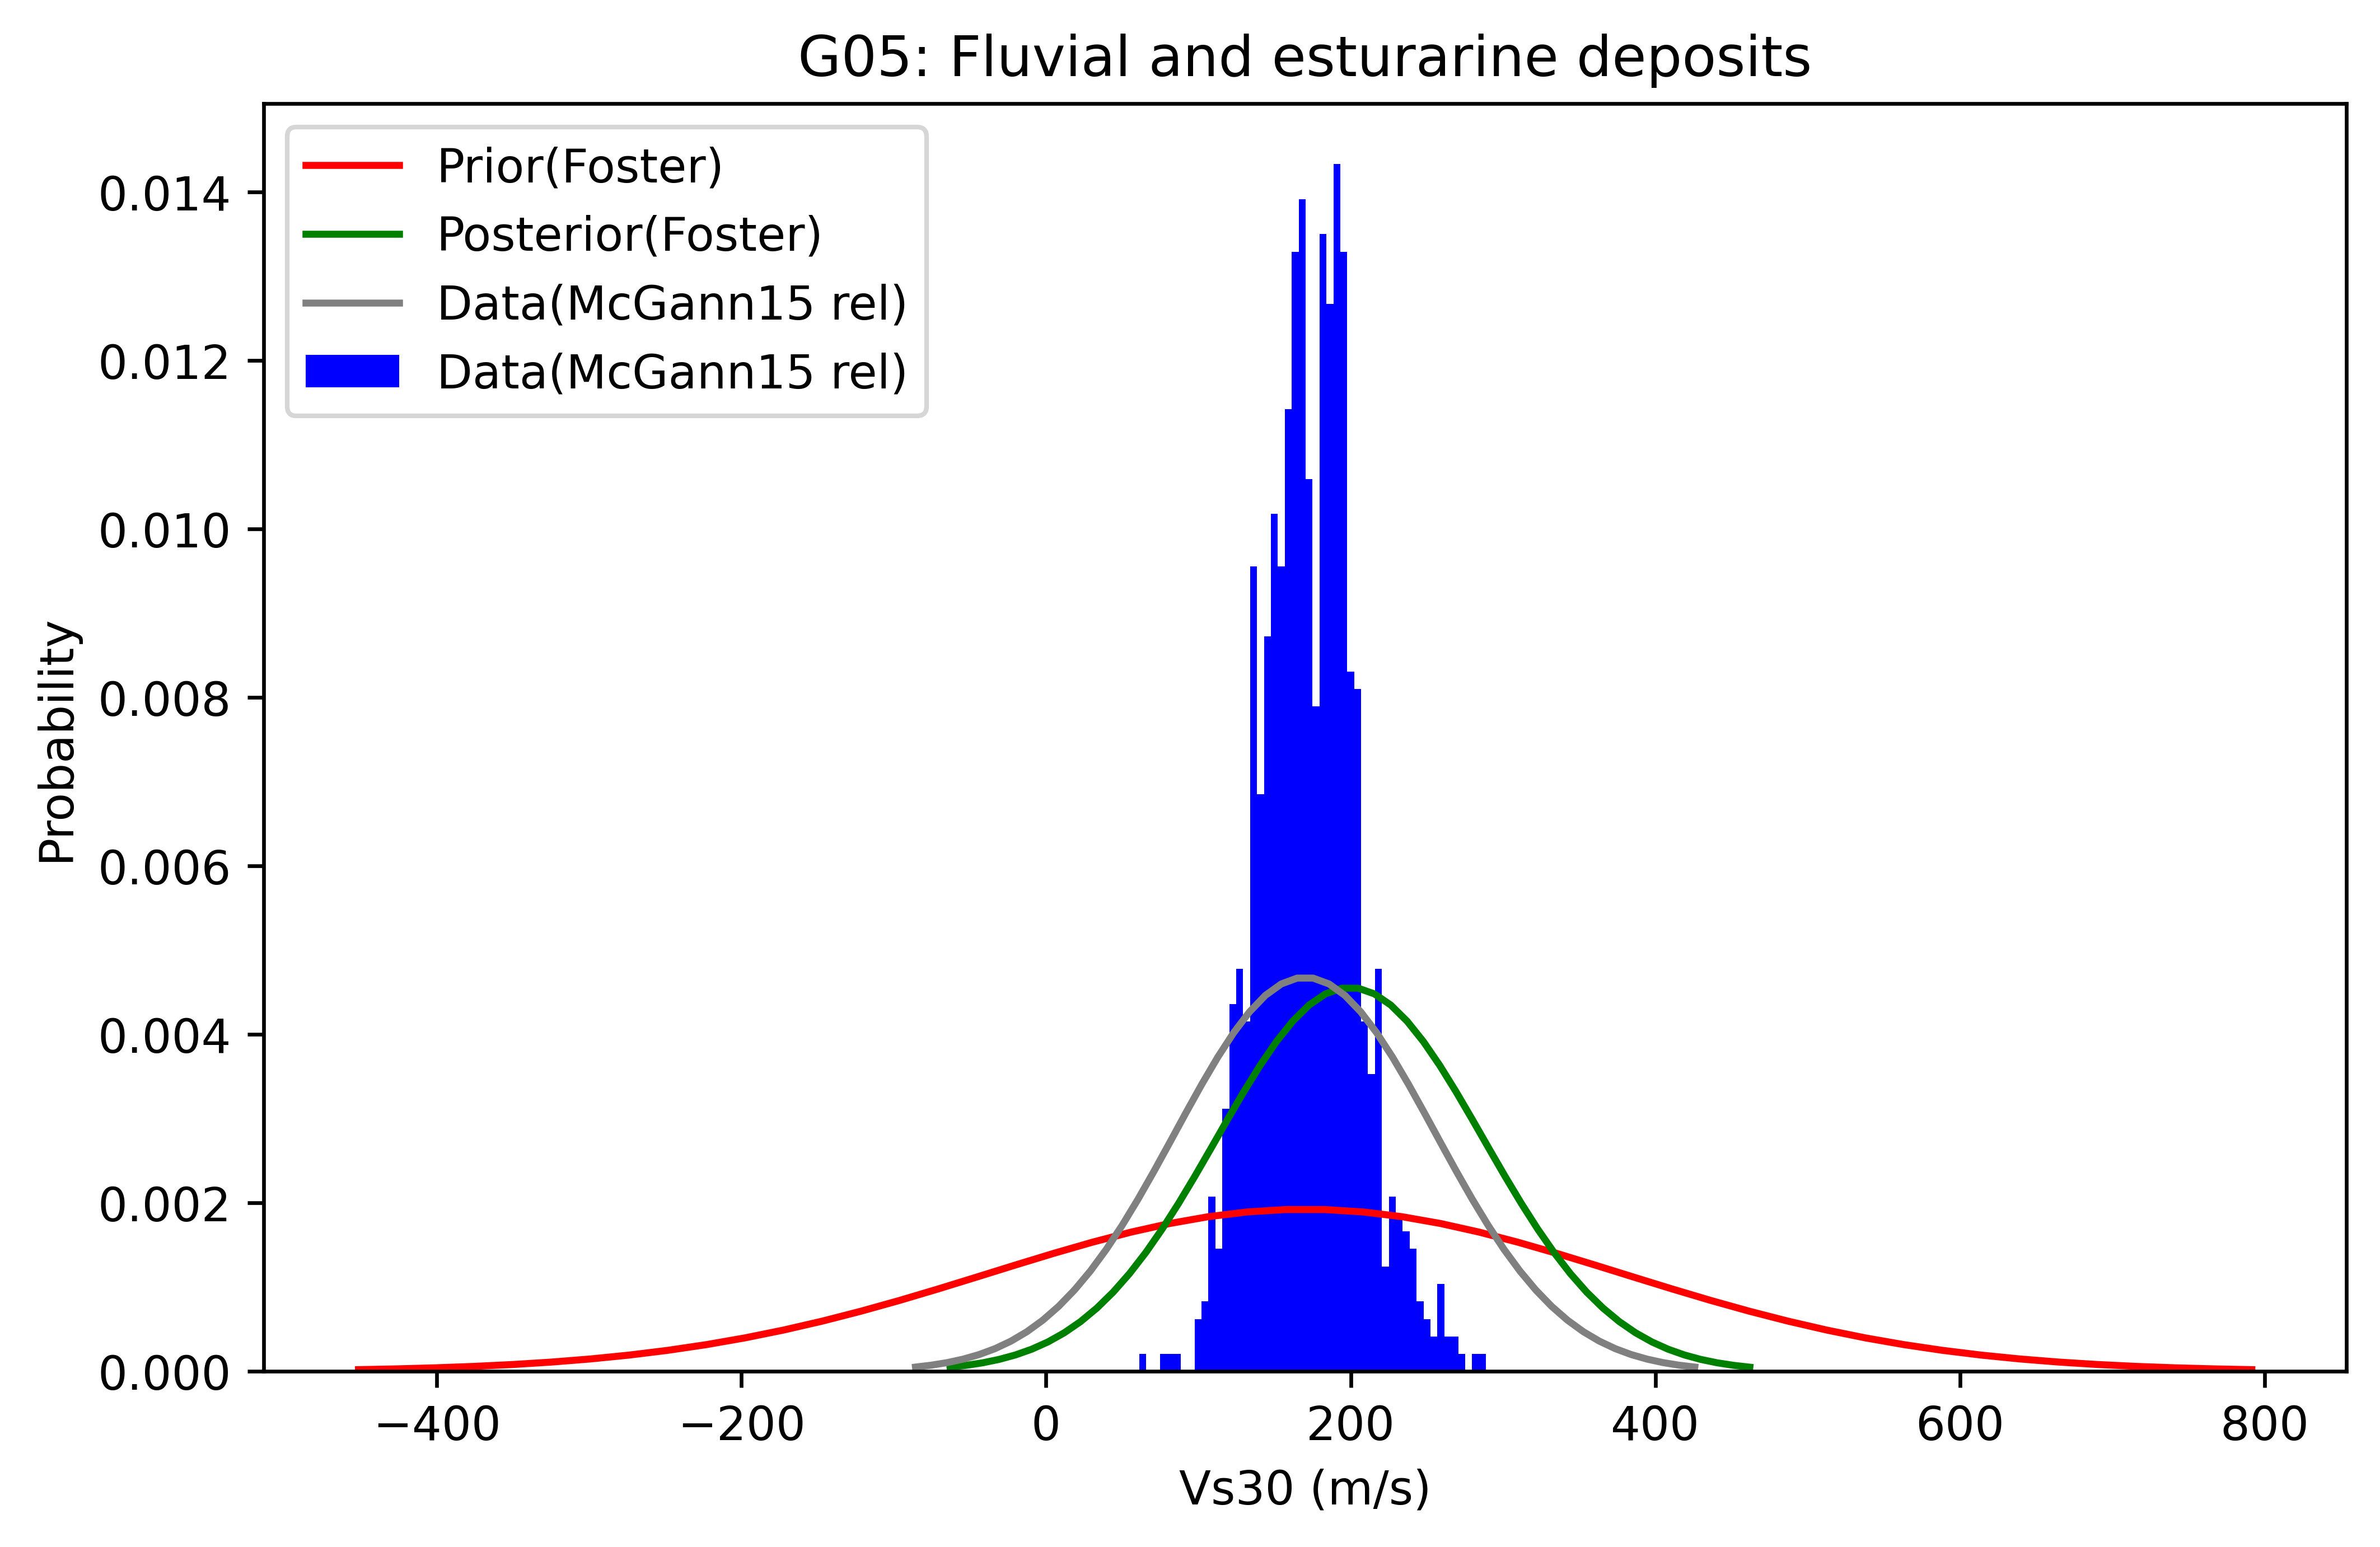

In [356]:

data_dict = {
        "Prior(Foster)": [prior_means,prior_errors,'red'],
        "Posterior(Foster)": [posterior_means,posterior_errors,'green'],
        "Data(McGann15 rel)": [new_posterior_means,new_posterior_errors,"gray"]
}

for i in range(1,4):
    plot_hist_dist(data_dict,i)

        

# Clustering

In [357]:
import sklearn
sklearn
sklearn.__version__
import importlib
from vs30 import sites_cluster
importlib.reload(sites_cluster)

<module 'vs30.sites_cluster' from '/data/sharing/QuakeCoRE/Vs30/vs30/sites_cluster.py'>

In [358]:
clustered_sites=sites_cluster.cluster(sites,min_group=100, eps=80000,letter="g")
features = np.column_stack((sites.easting.values, sites.northing.values))
print(clustered_sites.describe())


#for i in range(-1,cluster_num):
#    print("i:{} {}".format(i,len(cluster_sites.loc[cluster_sites.gcluster==i])))
clustered_sites.to_csv(outdir/"clustered_sites.csv")


            easting      northing          vs30  geo_model_idx           gid  \
count  2.650100e+04  2.650100e+04  26501.000000   26501.000000  26501.000000   
mean   1.676731e+06  5.434787e+06    170.151710       7.687936      6.687936   
std    1.381684e+05  3.132343e+05     29.631595       3.446383      3.446383   
min    1.240360e+06  4.829226e+06     22.952834       1.000000      0.000000   
25%    1.571677e+06  5.181377e+06    149.664585       4.000000      3.000000   
50%    1.576456e+06  5.186080e+06    170.064134       8.000000      7.000000   
75%    1.793444e+06  5.813151e+06    190.155105      10.000000      9.000000   
max    2.068359e+06  6.095989e+06    300.275847      15.000000     14.000000   

       uncertainty      gcluster  
count      26501.0  26501.000000  
mean           0.5      0.483906  
std            0.0      0.803680  
min            0.5     -1.000000  
25%            0.5      0.000000  
50%            0.5      0.000000  
75%            0.5      1.000000  

Gid=0 # clusters=3
Gid=1 # clusters=2
Gid=2 # clusters=3
Gid=3 # clusters=5
Gid=4 # clusters=1
Gid=5 # clusters=5
Gid=6 # clusters=1
Gid=7 # clusters=3
Gid=8 # clusters=1
Gid=9 # clusters=5
Gid=10 # clusters=1
Gid=11 # clusters=4
Gid=12 # clusters=2
Gid=13 # clusters=1
Gid=14 # clusters=3


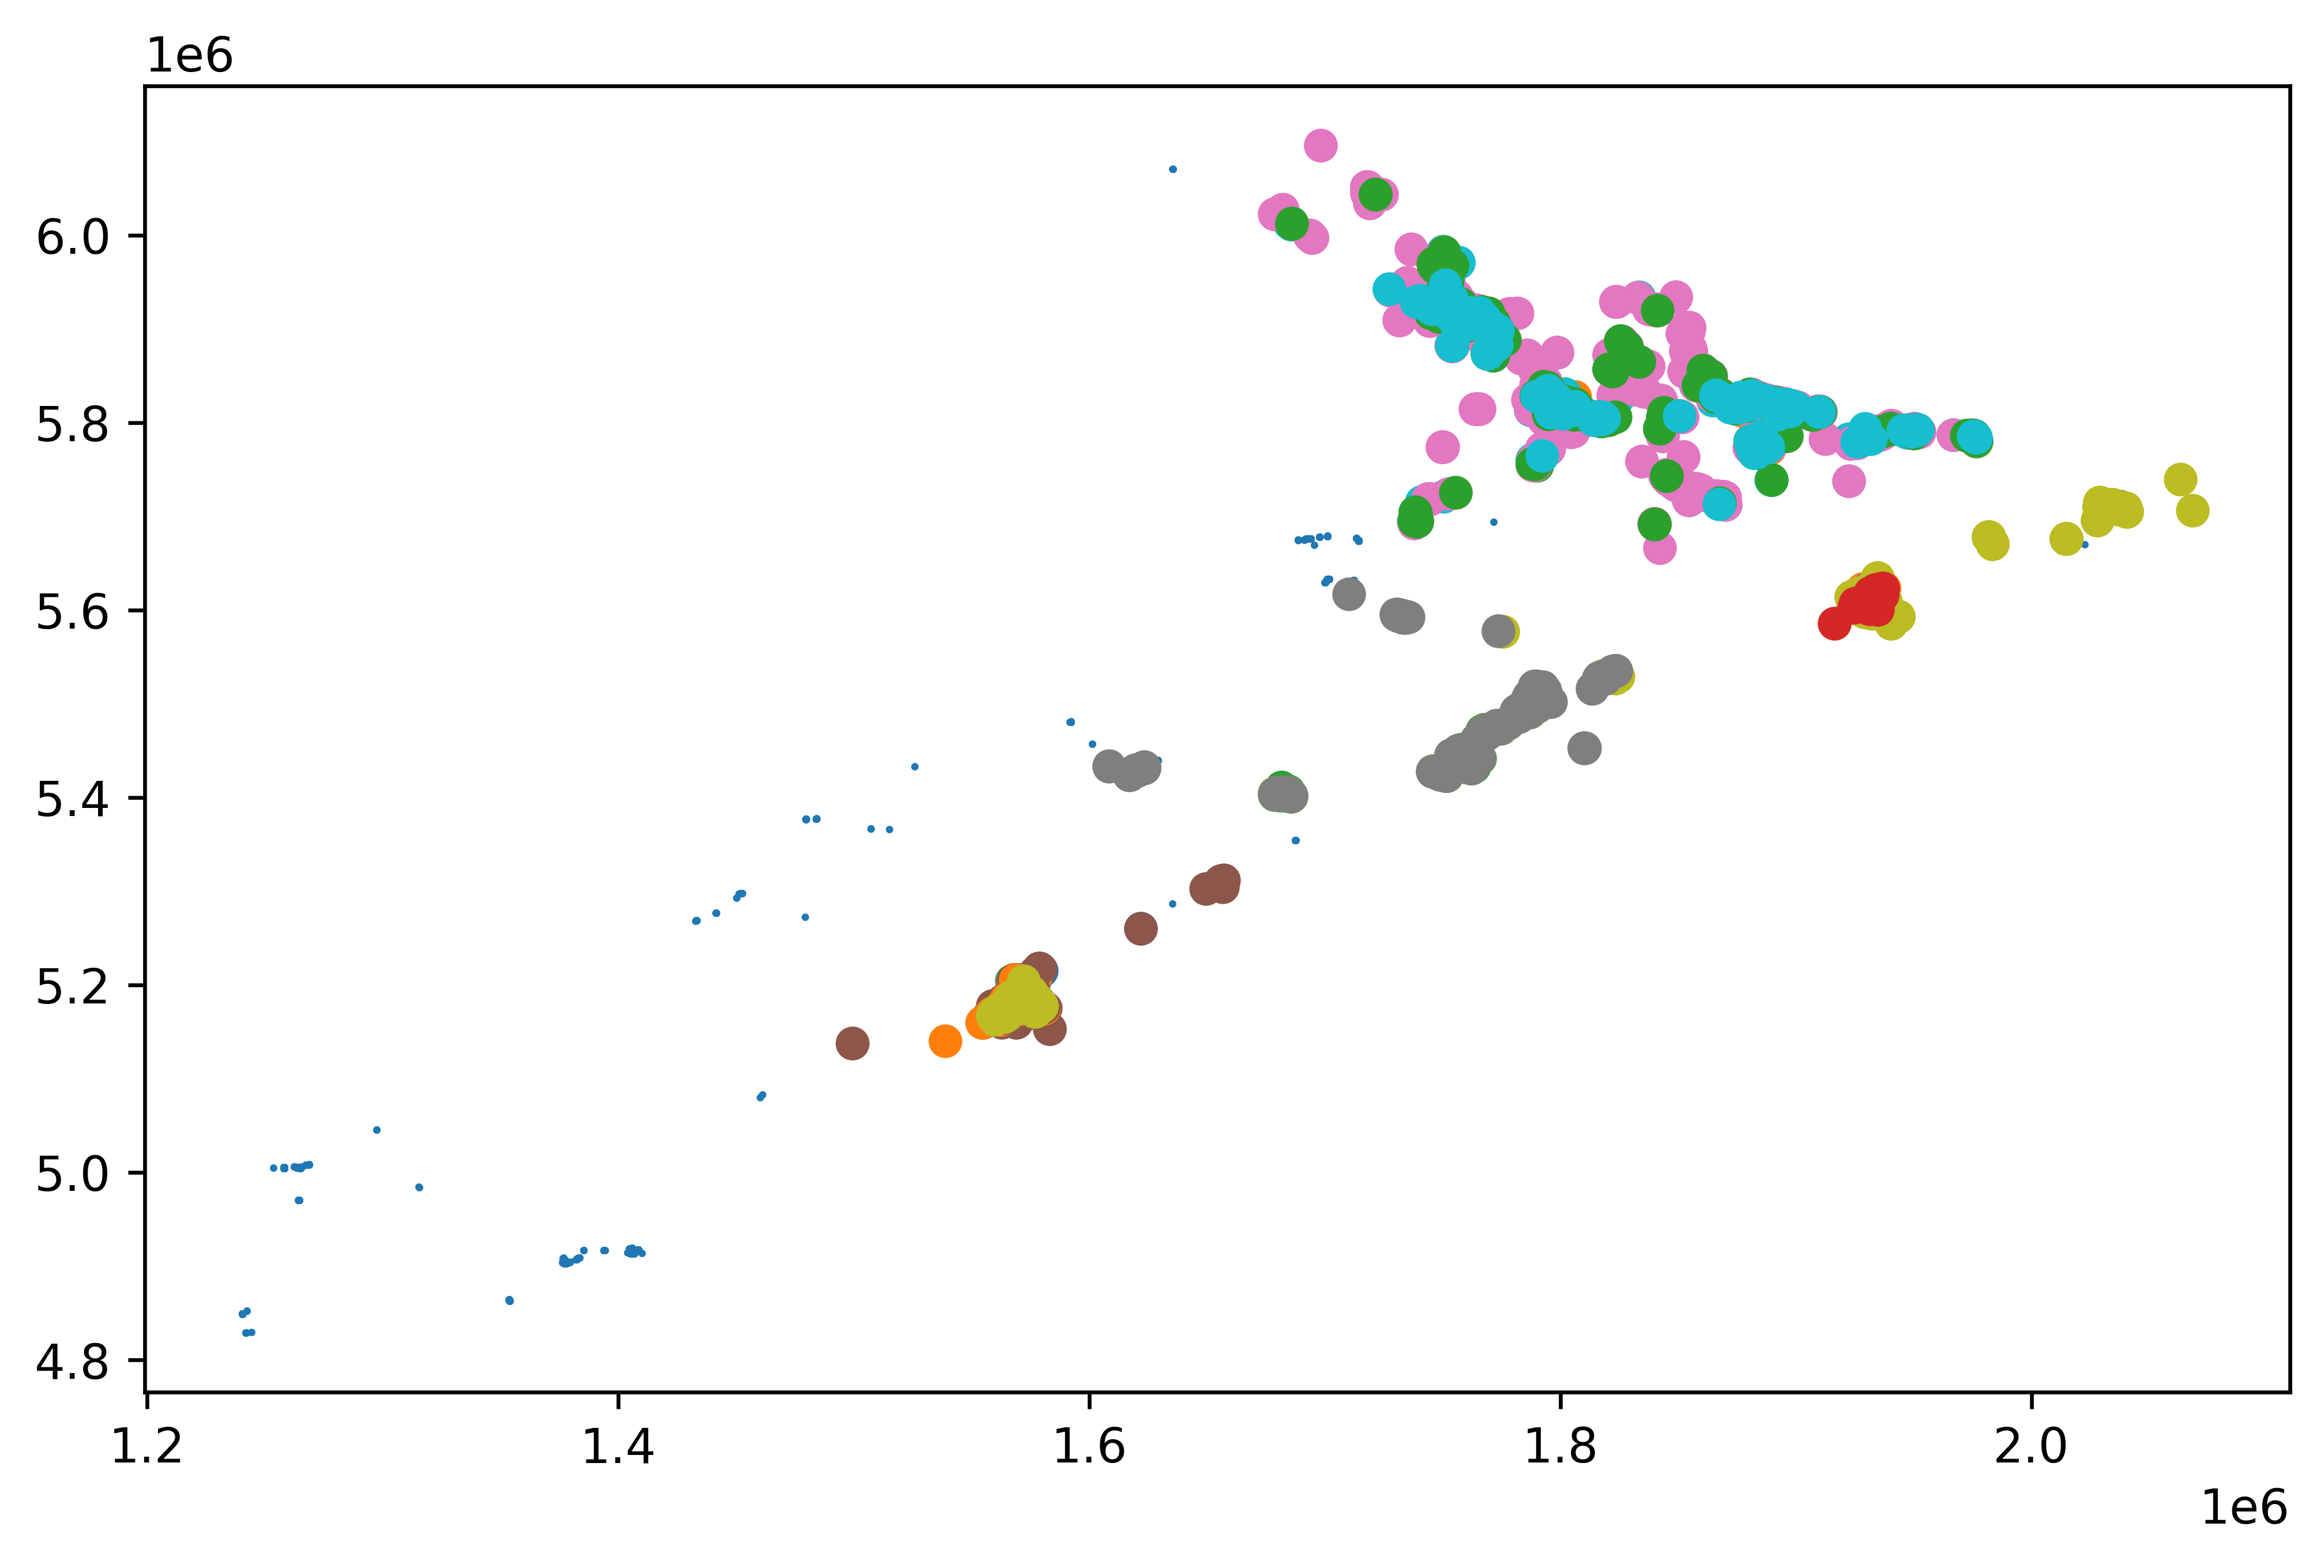

In [359]:
fig,ax=plt.subplots()

ax.scatter(features[:,0],features[:,1],s=0.3)
for g in range(0,15):
#for g in range(0,1):
    clustered_sites_gid = clustered_sites.loc[clustered_sites.gid==g]
    counts = clustered_sites_gid.nunique()
    print("Gid={} # clusters={}".format(g,counts.gcluster))
    for c in range(0,counts.gcluster):
    #for c in range(0,1):
        a_cluster=clustered_sites_gid.loc[clustered_sites_gid.gcluster==c]
        ax.scatter(a_cluster.easting,a_cluster.northing)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


In [360]:
from vs30 import model
clustered_posterior=model.cluster_update(new_posterior,clustered_sites,"g")
clustered_posterior_means = clustered_posterior.T[0]
clustered_posterior_errors = clustered_posterior.T[1]*clustered_posterior_means

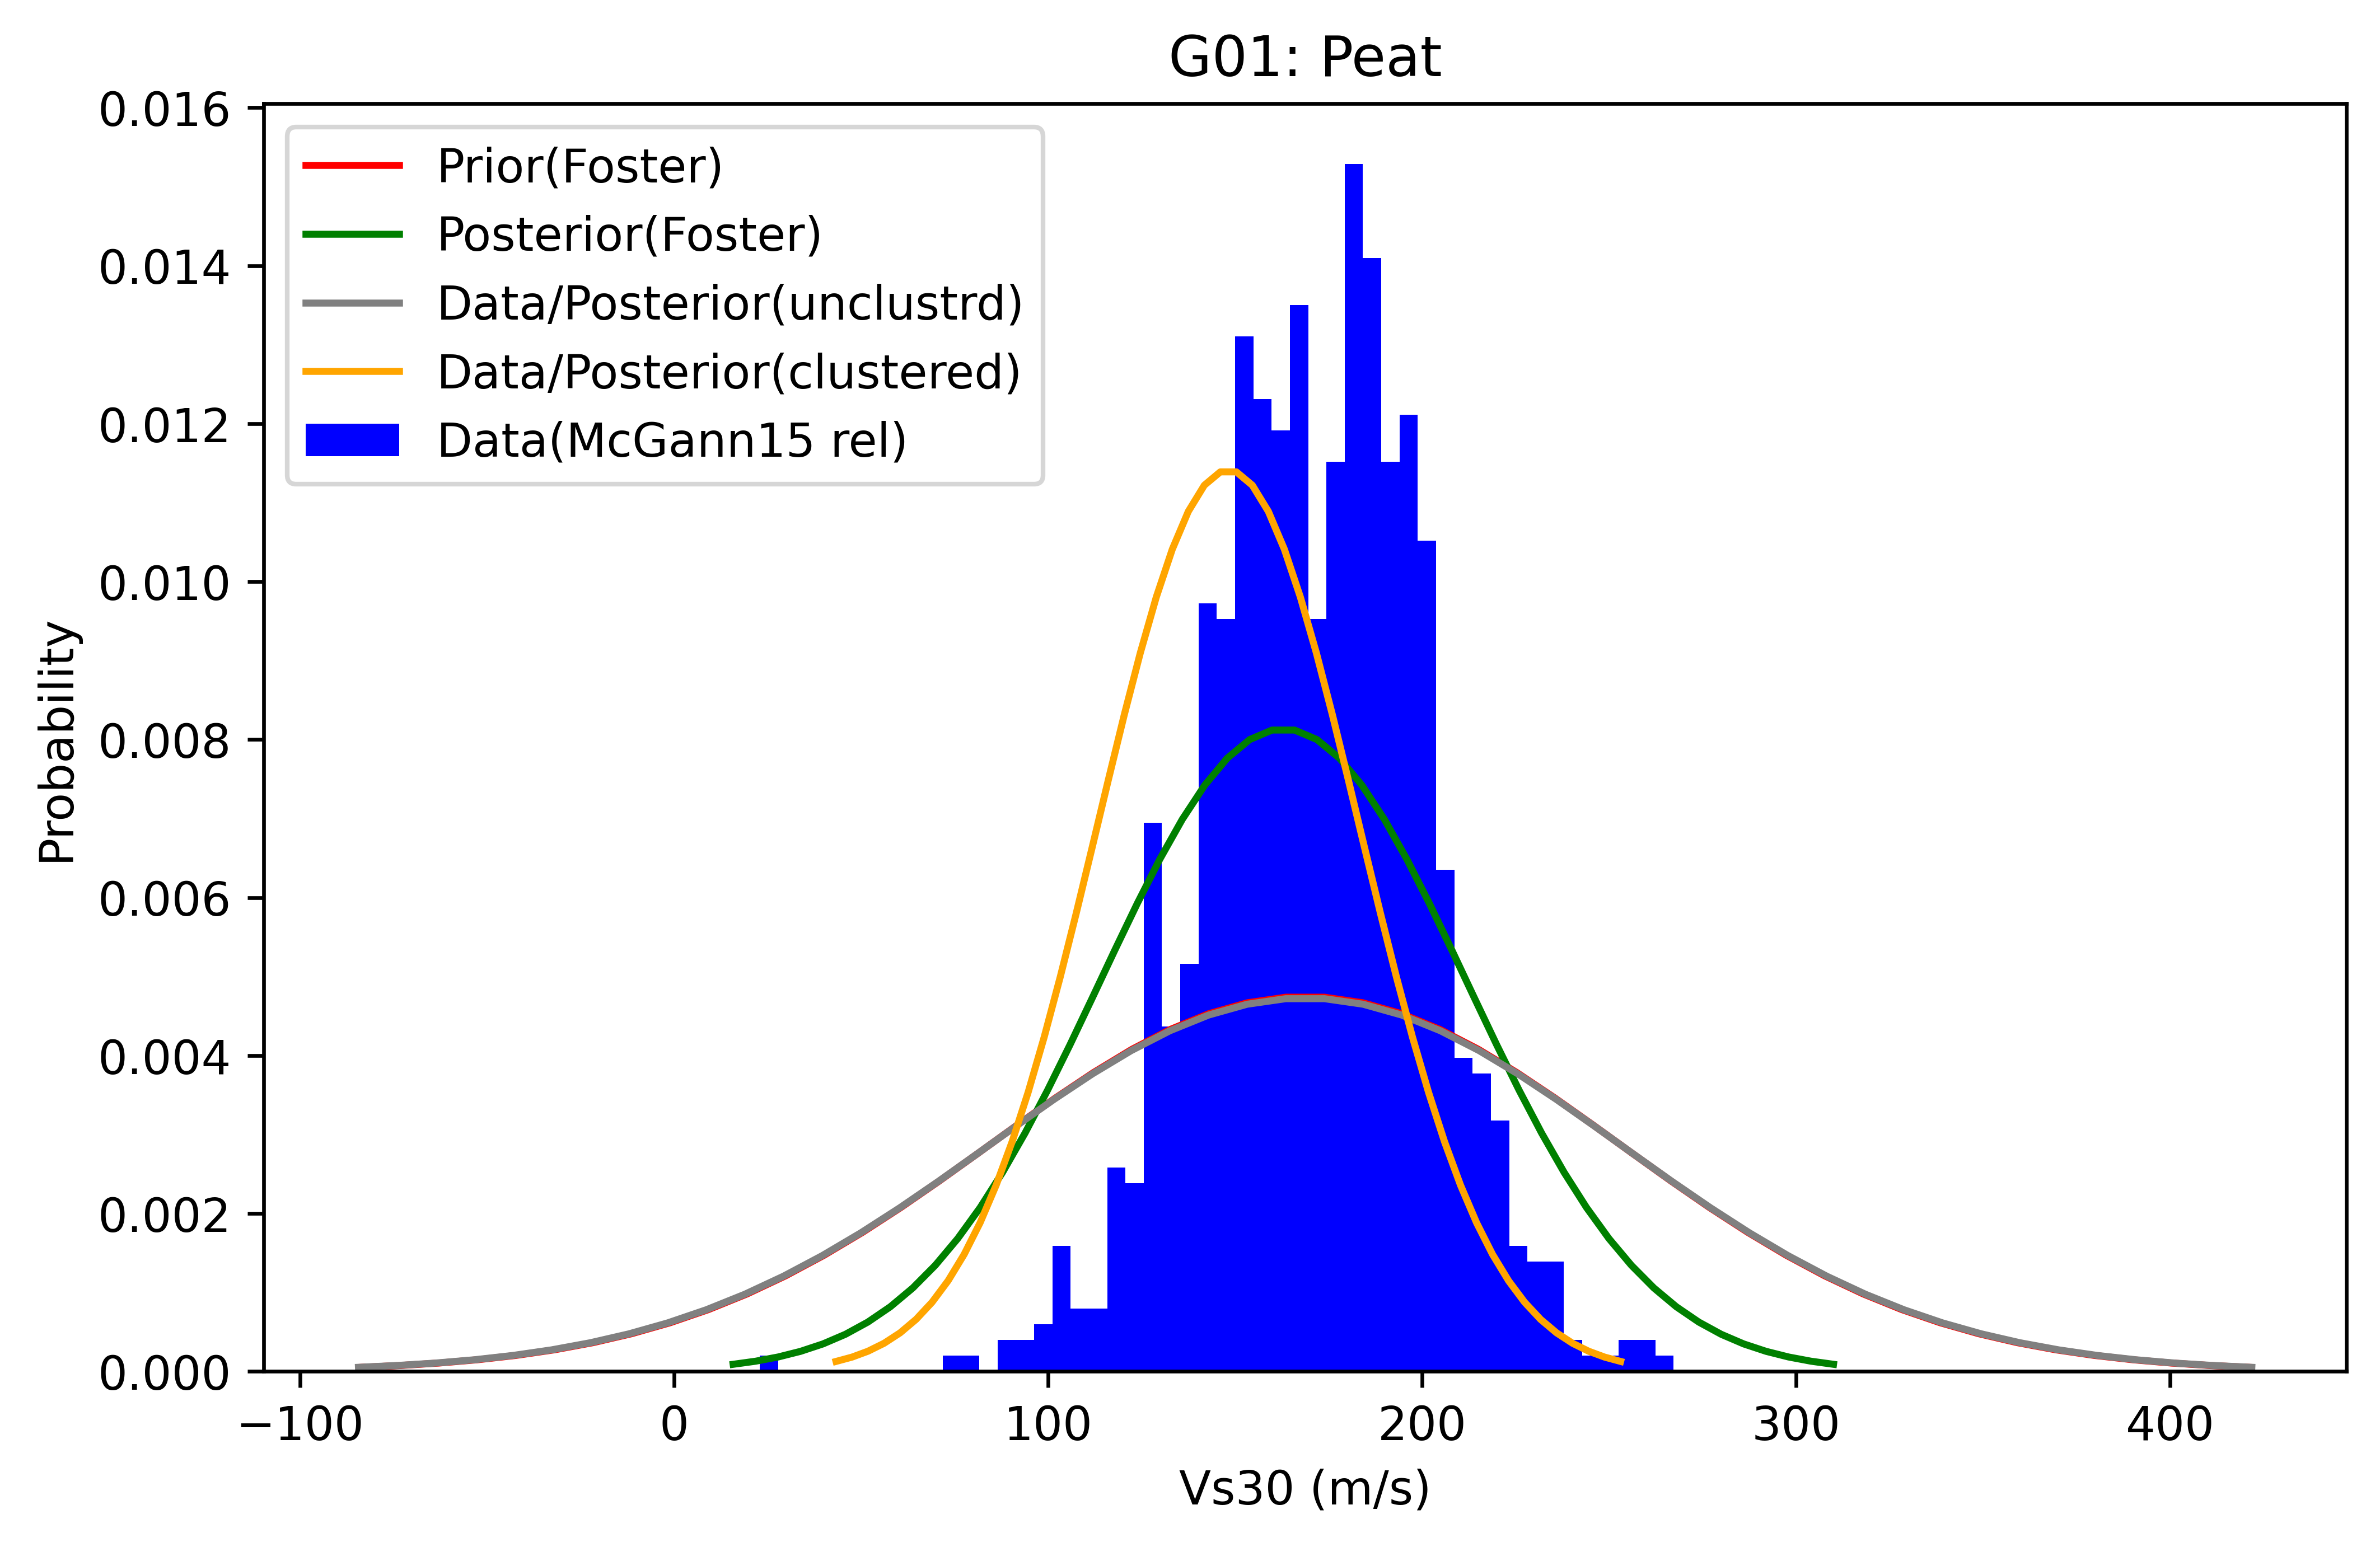

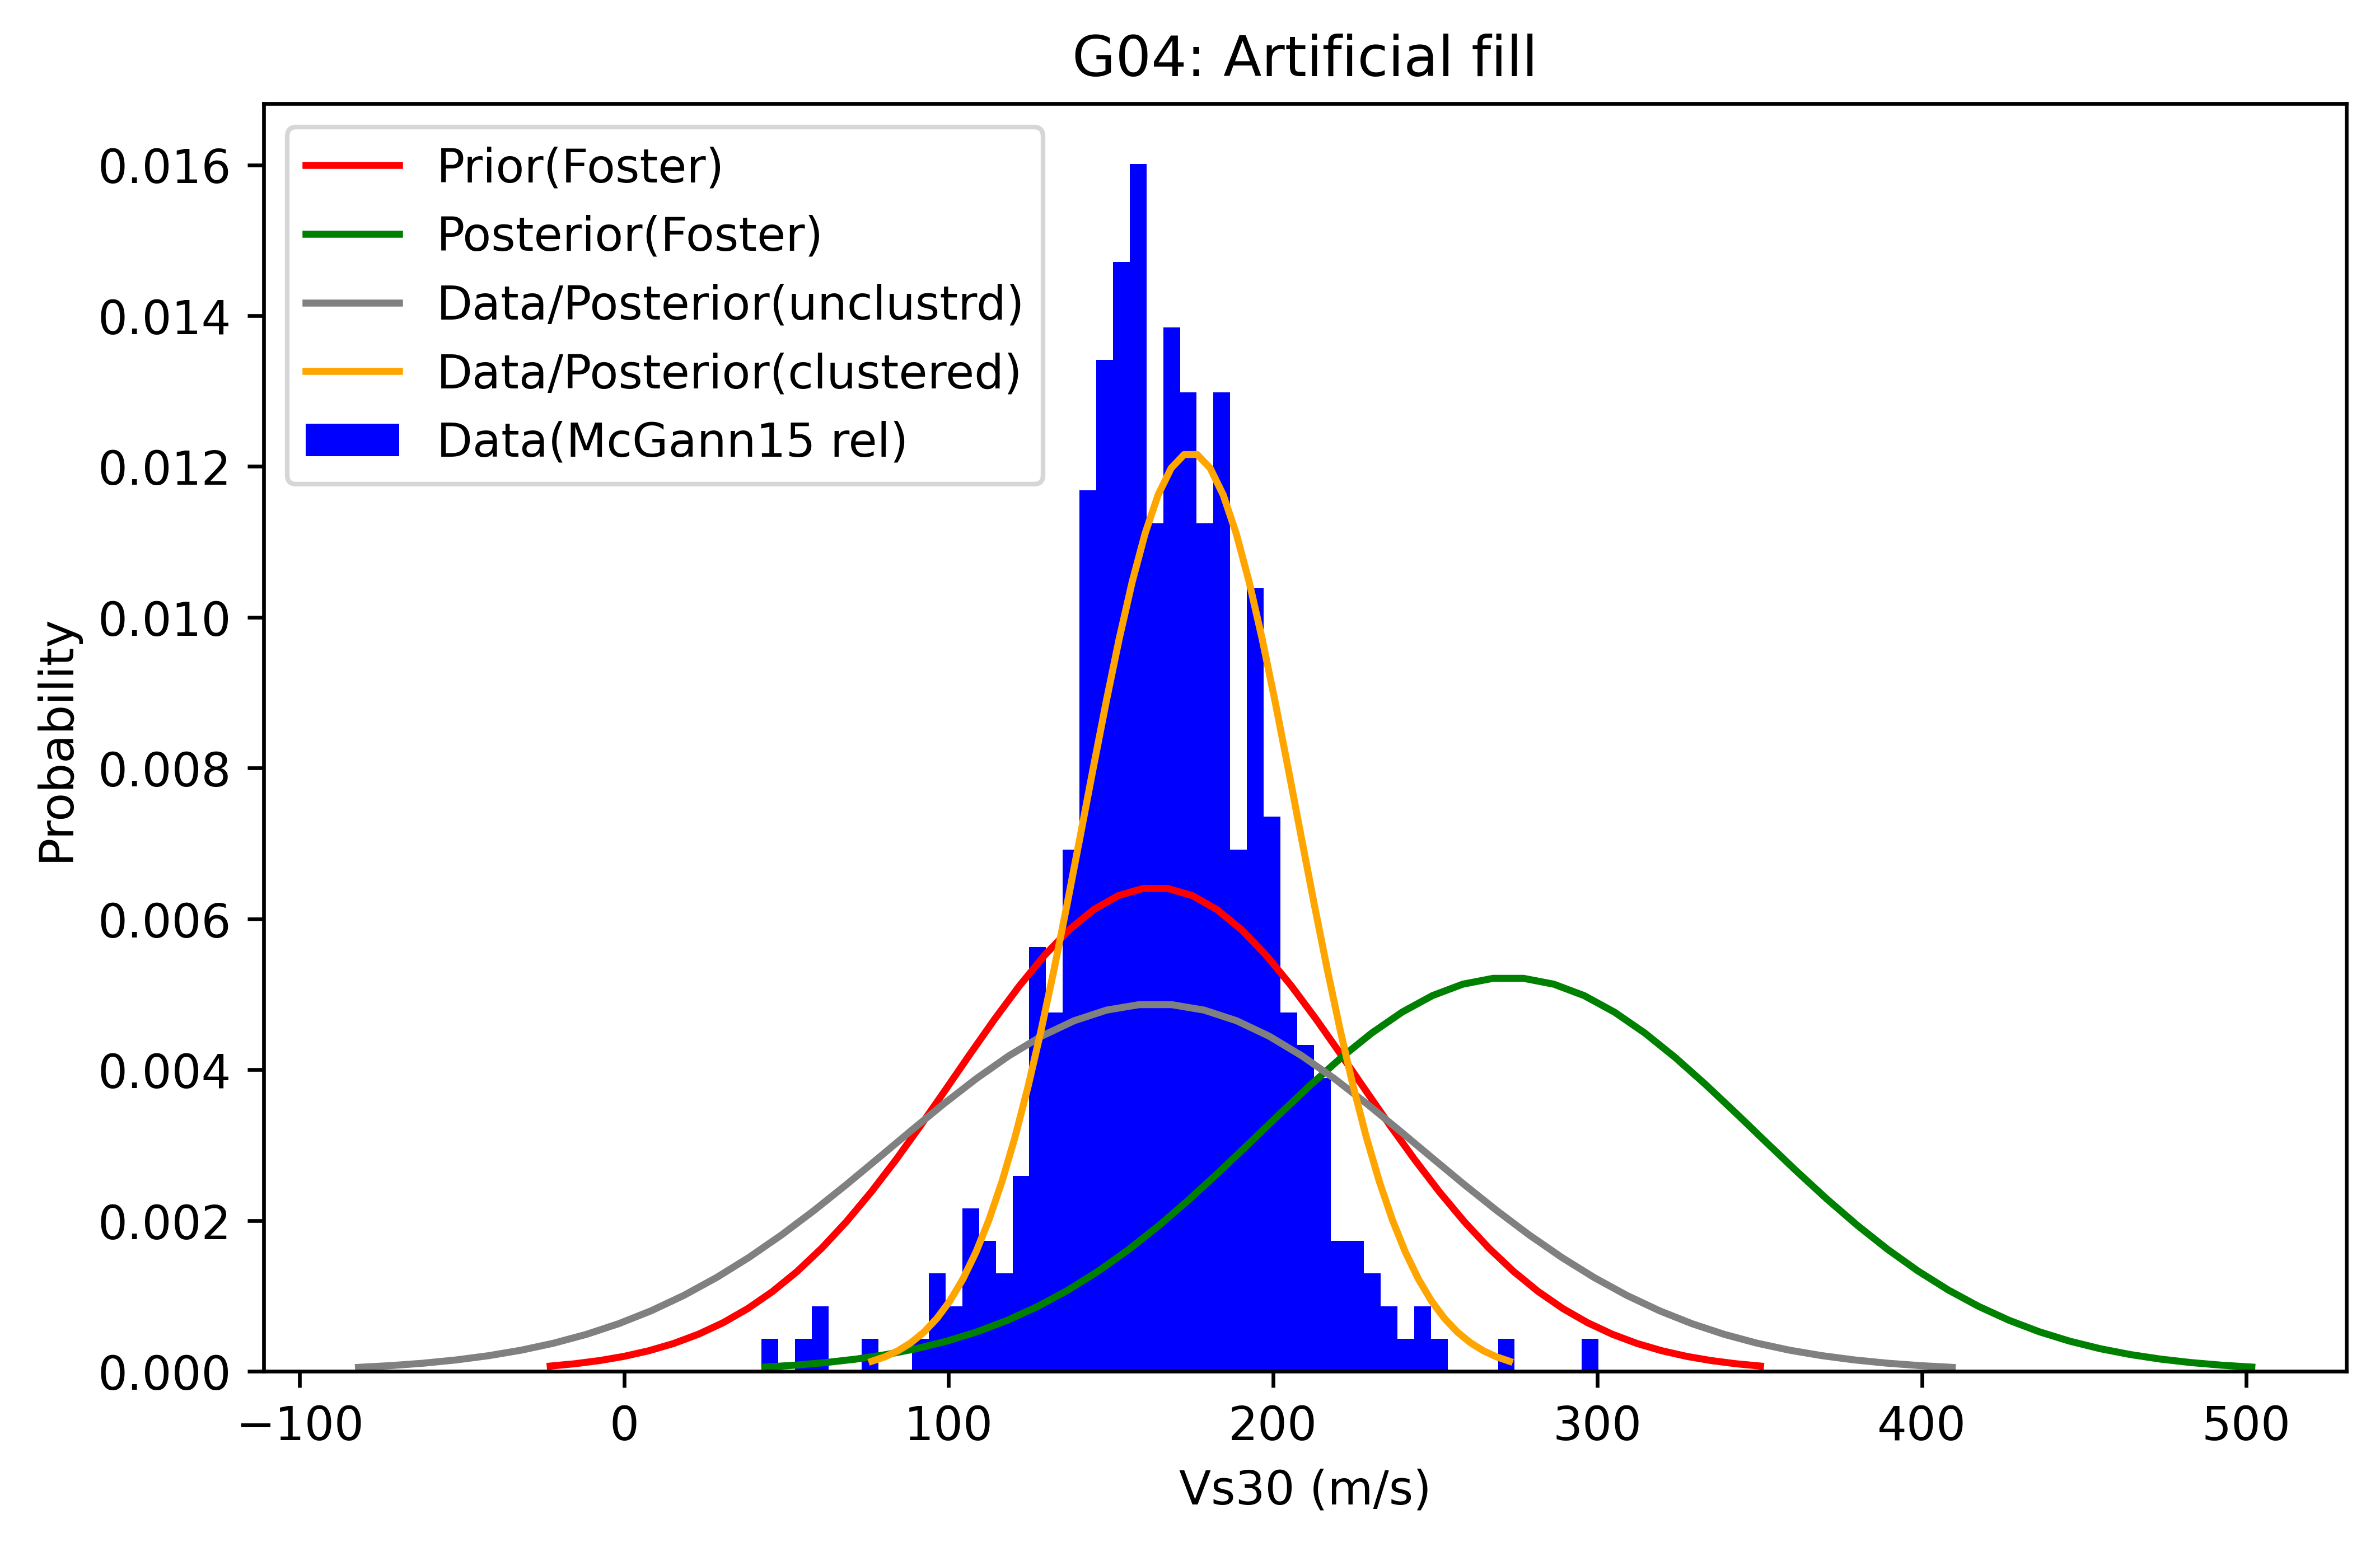

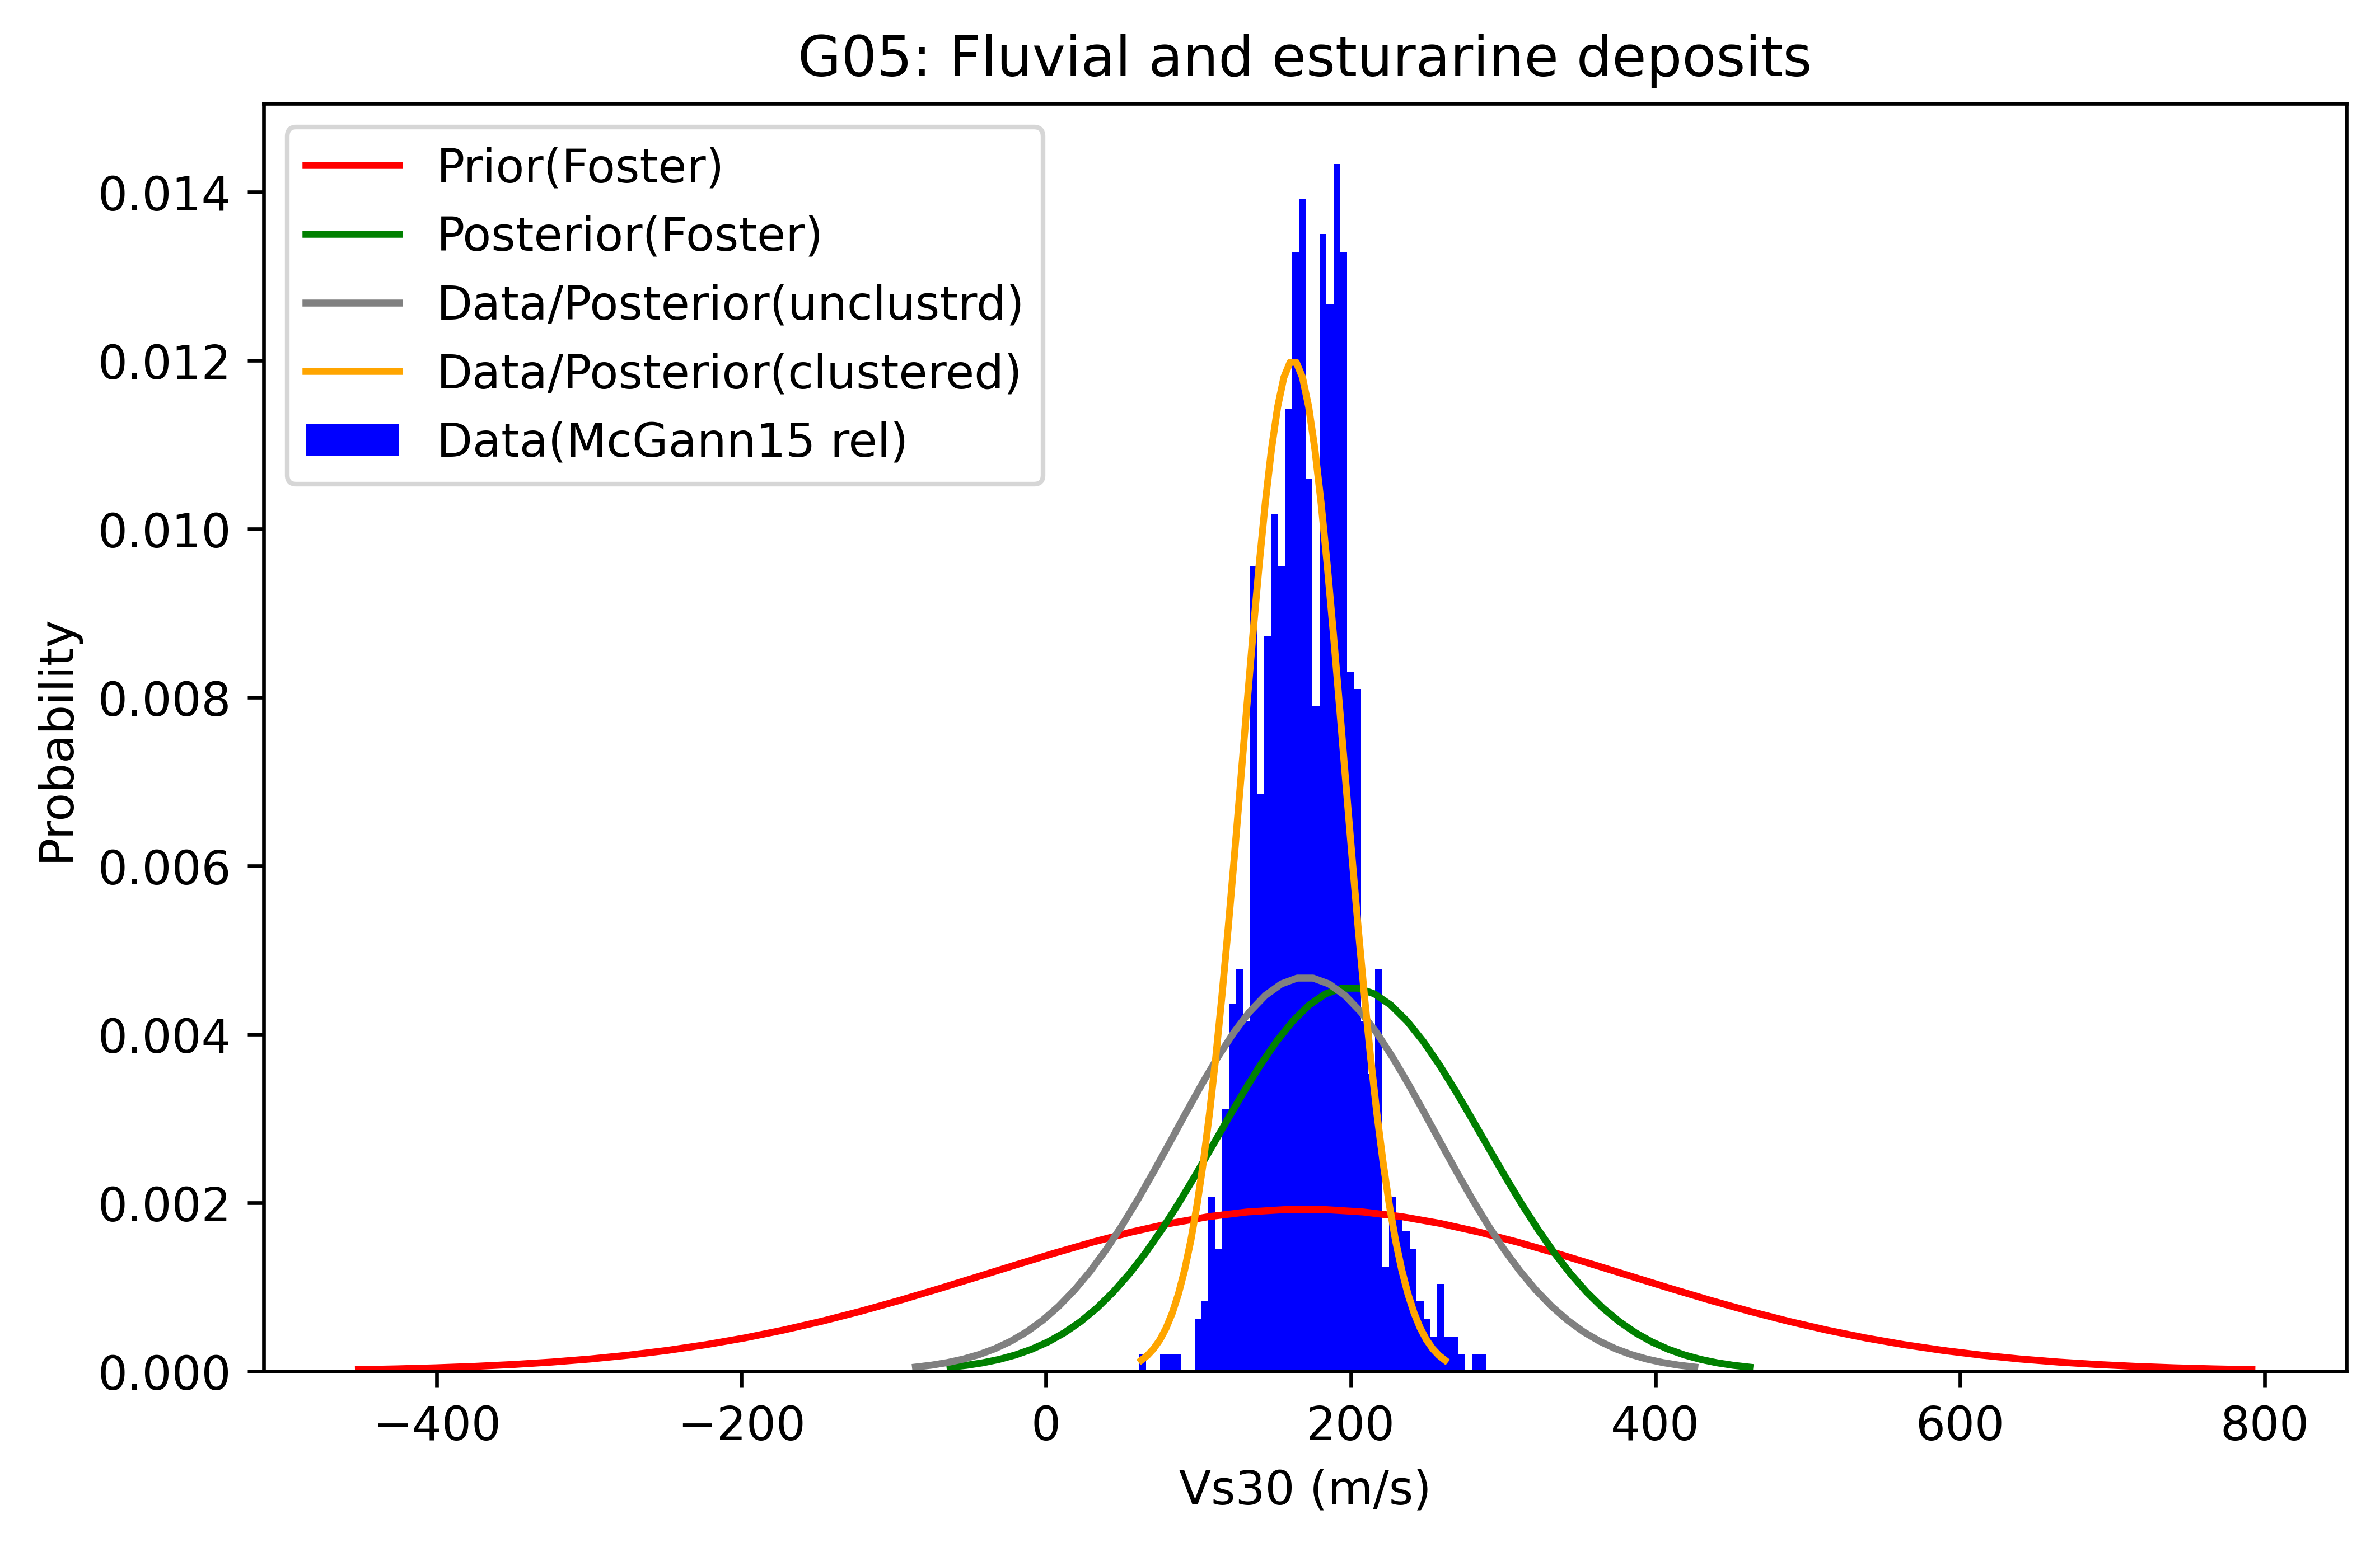

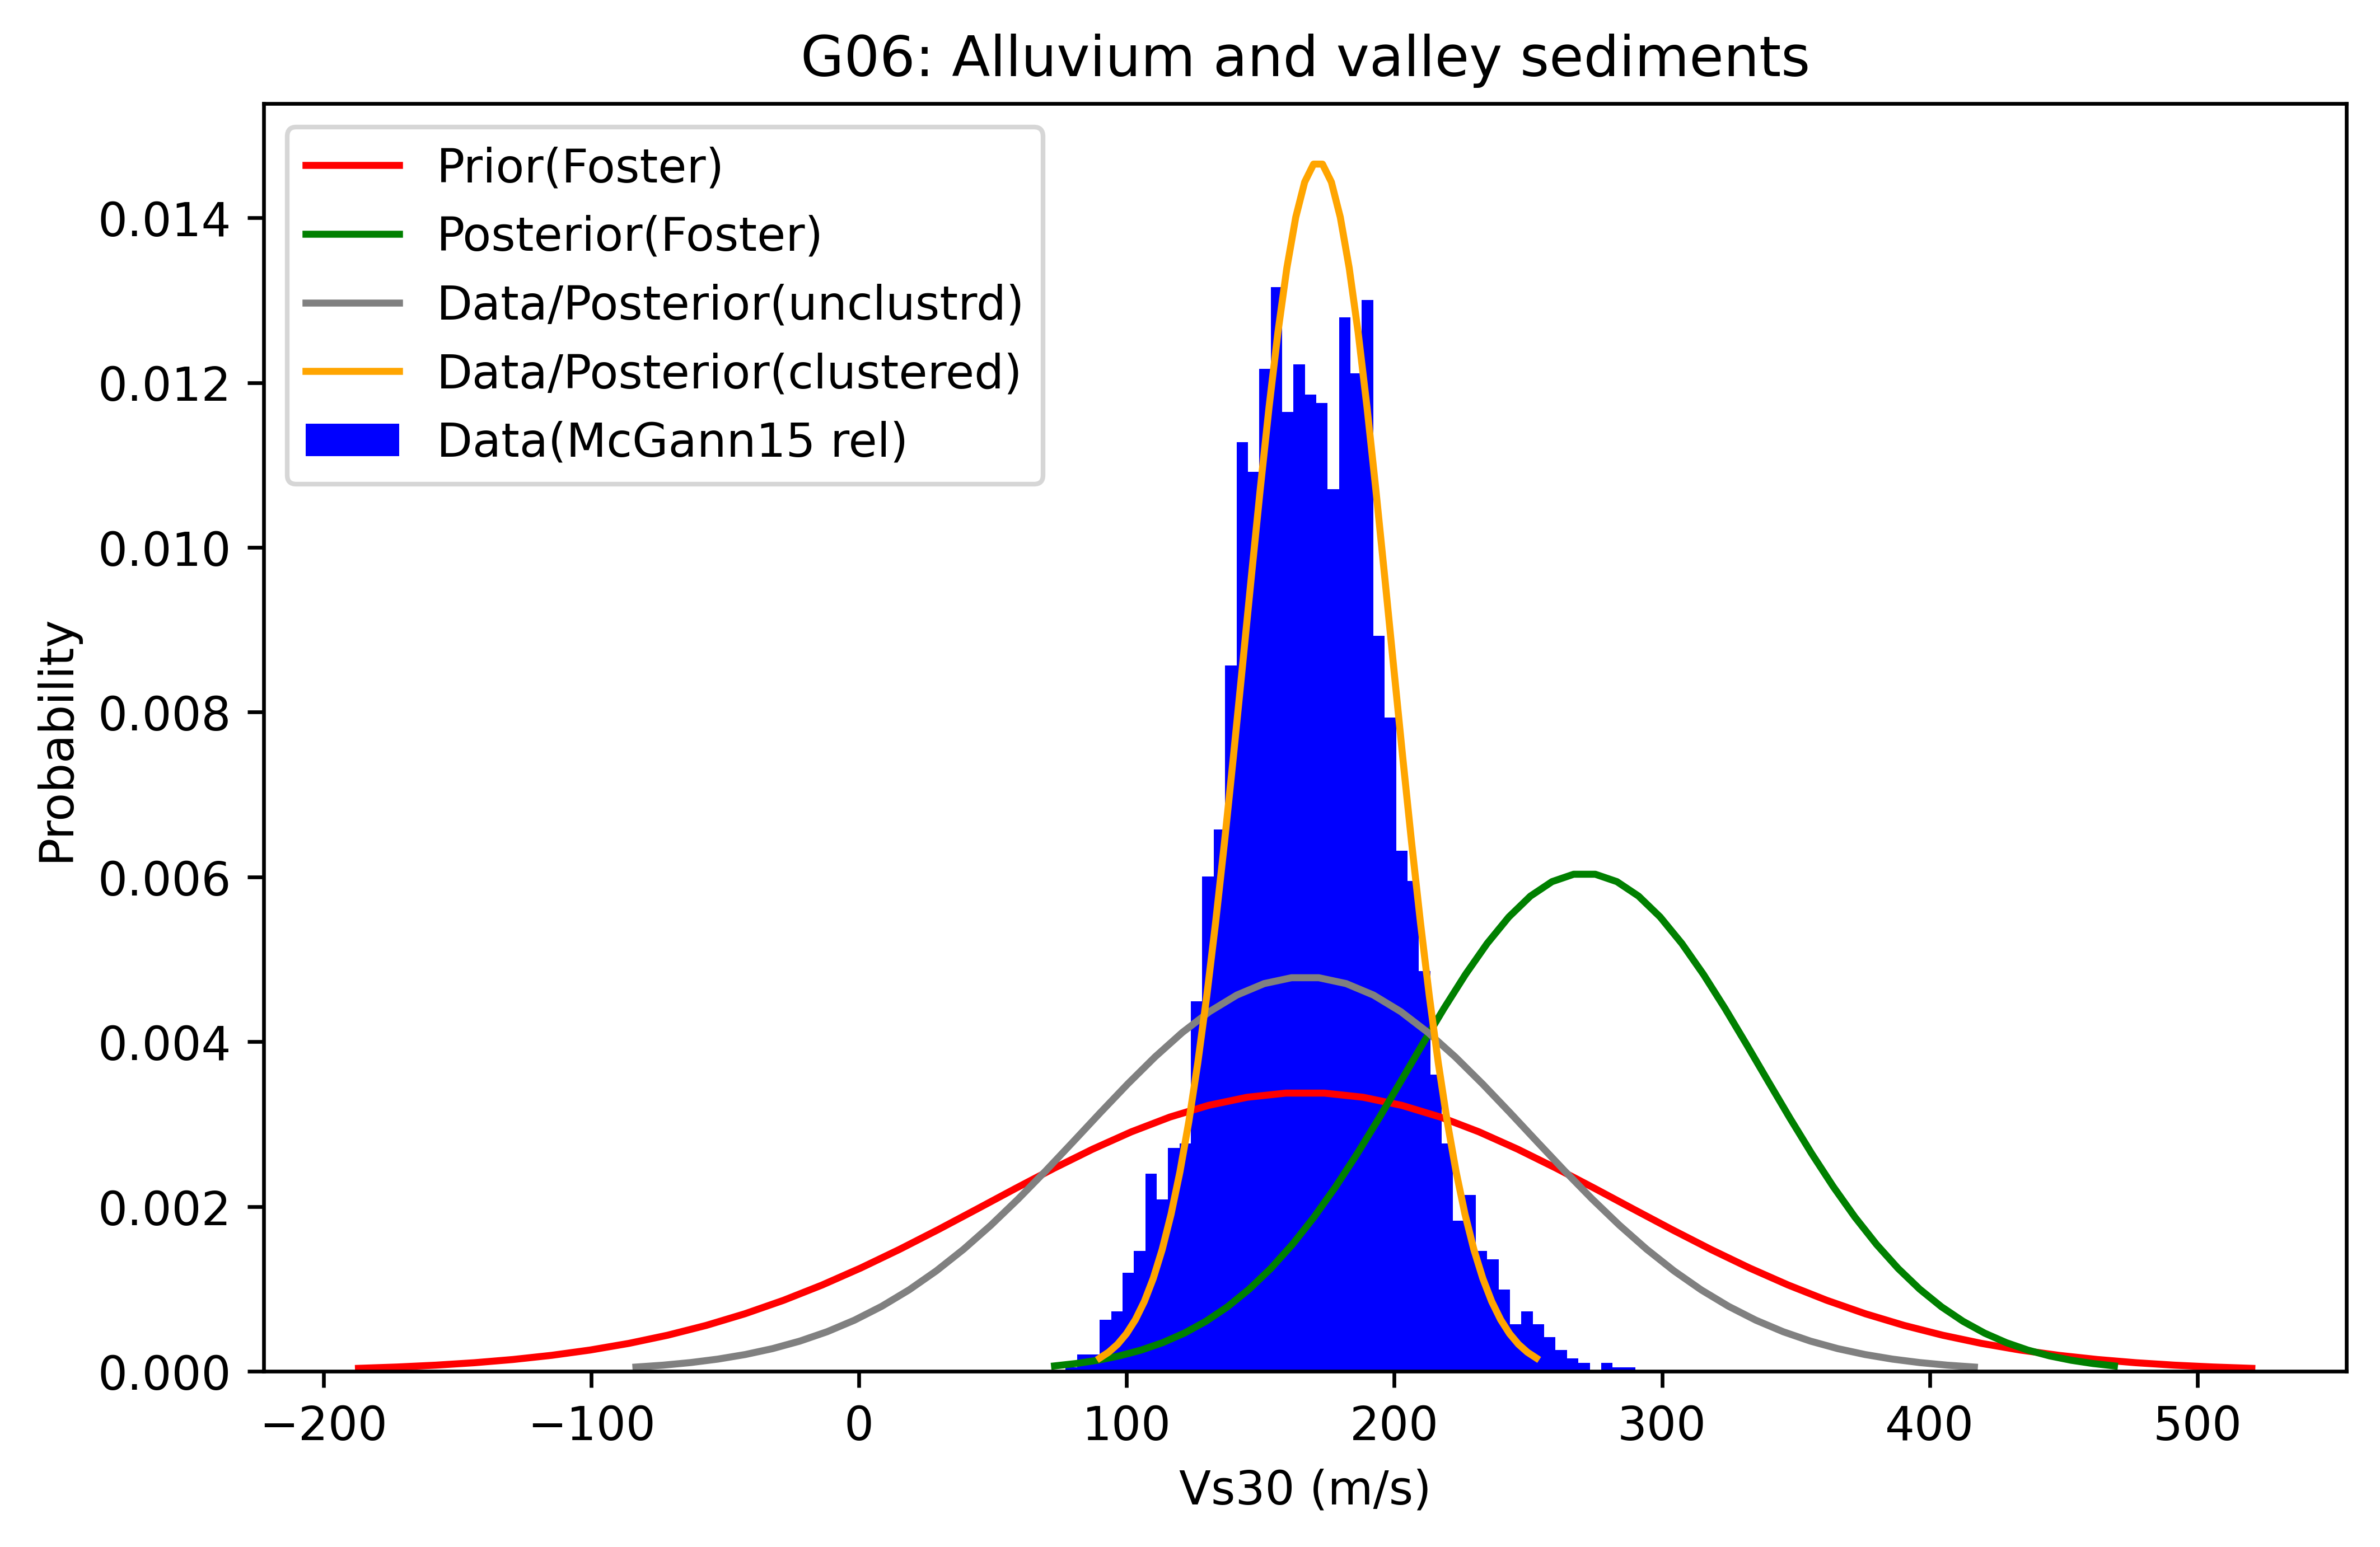

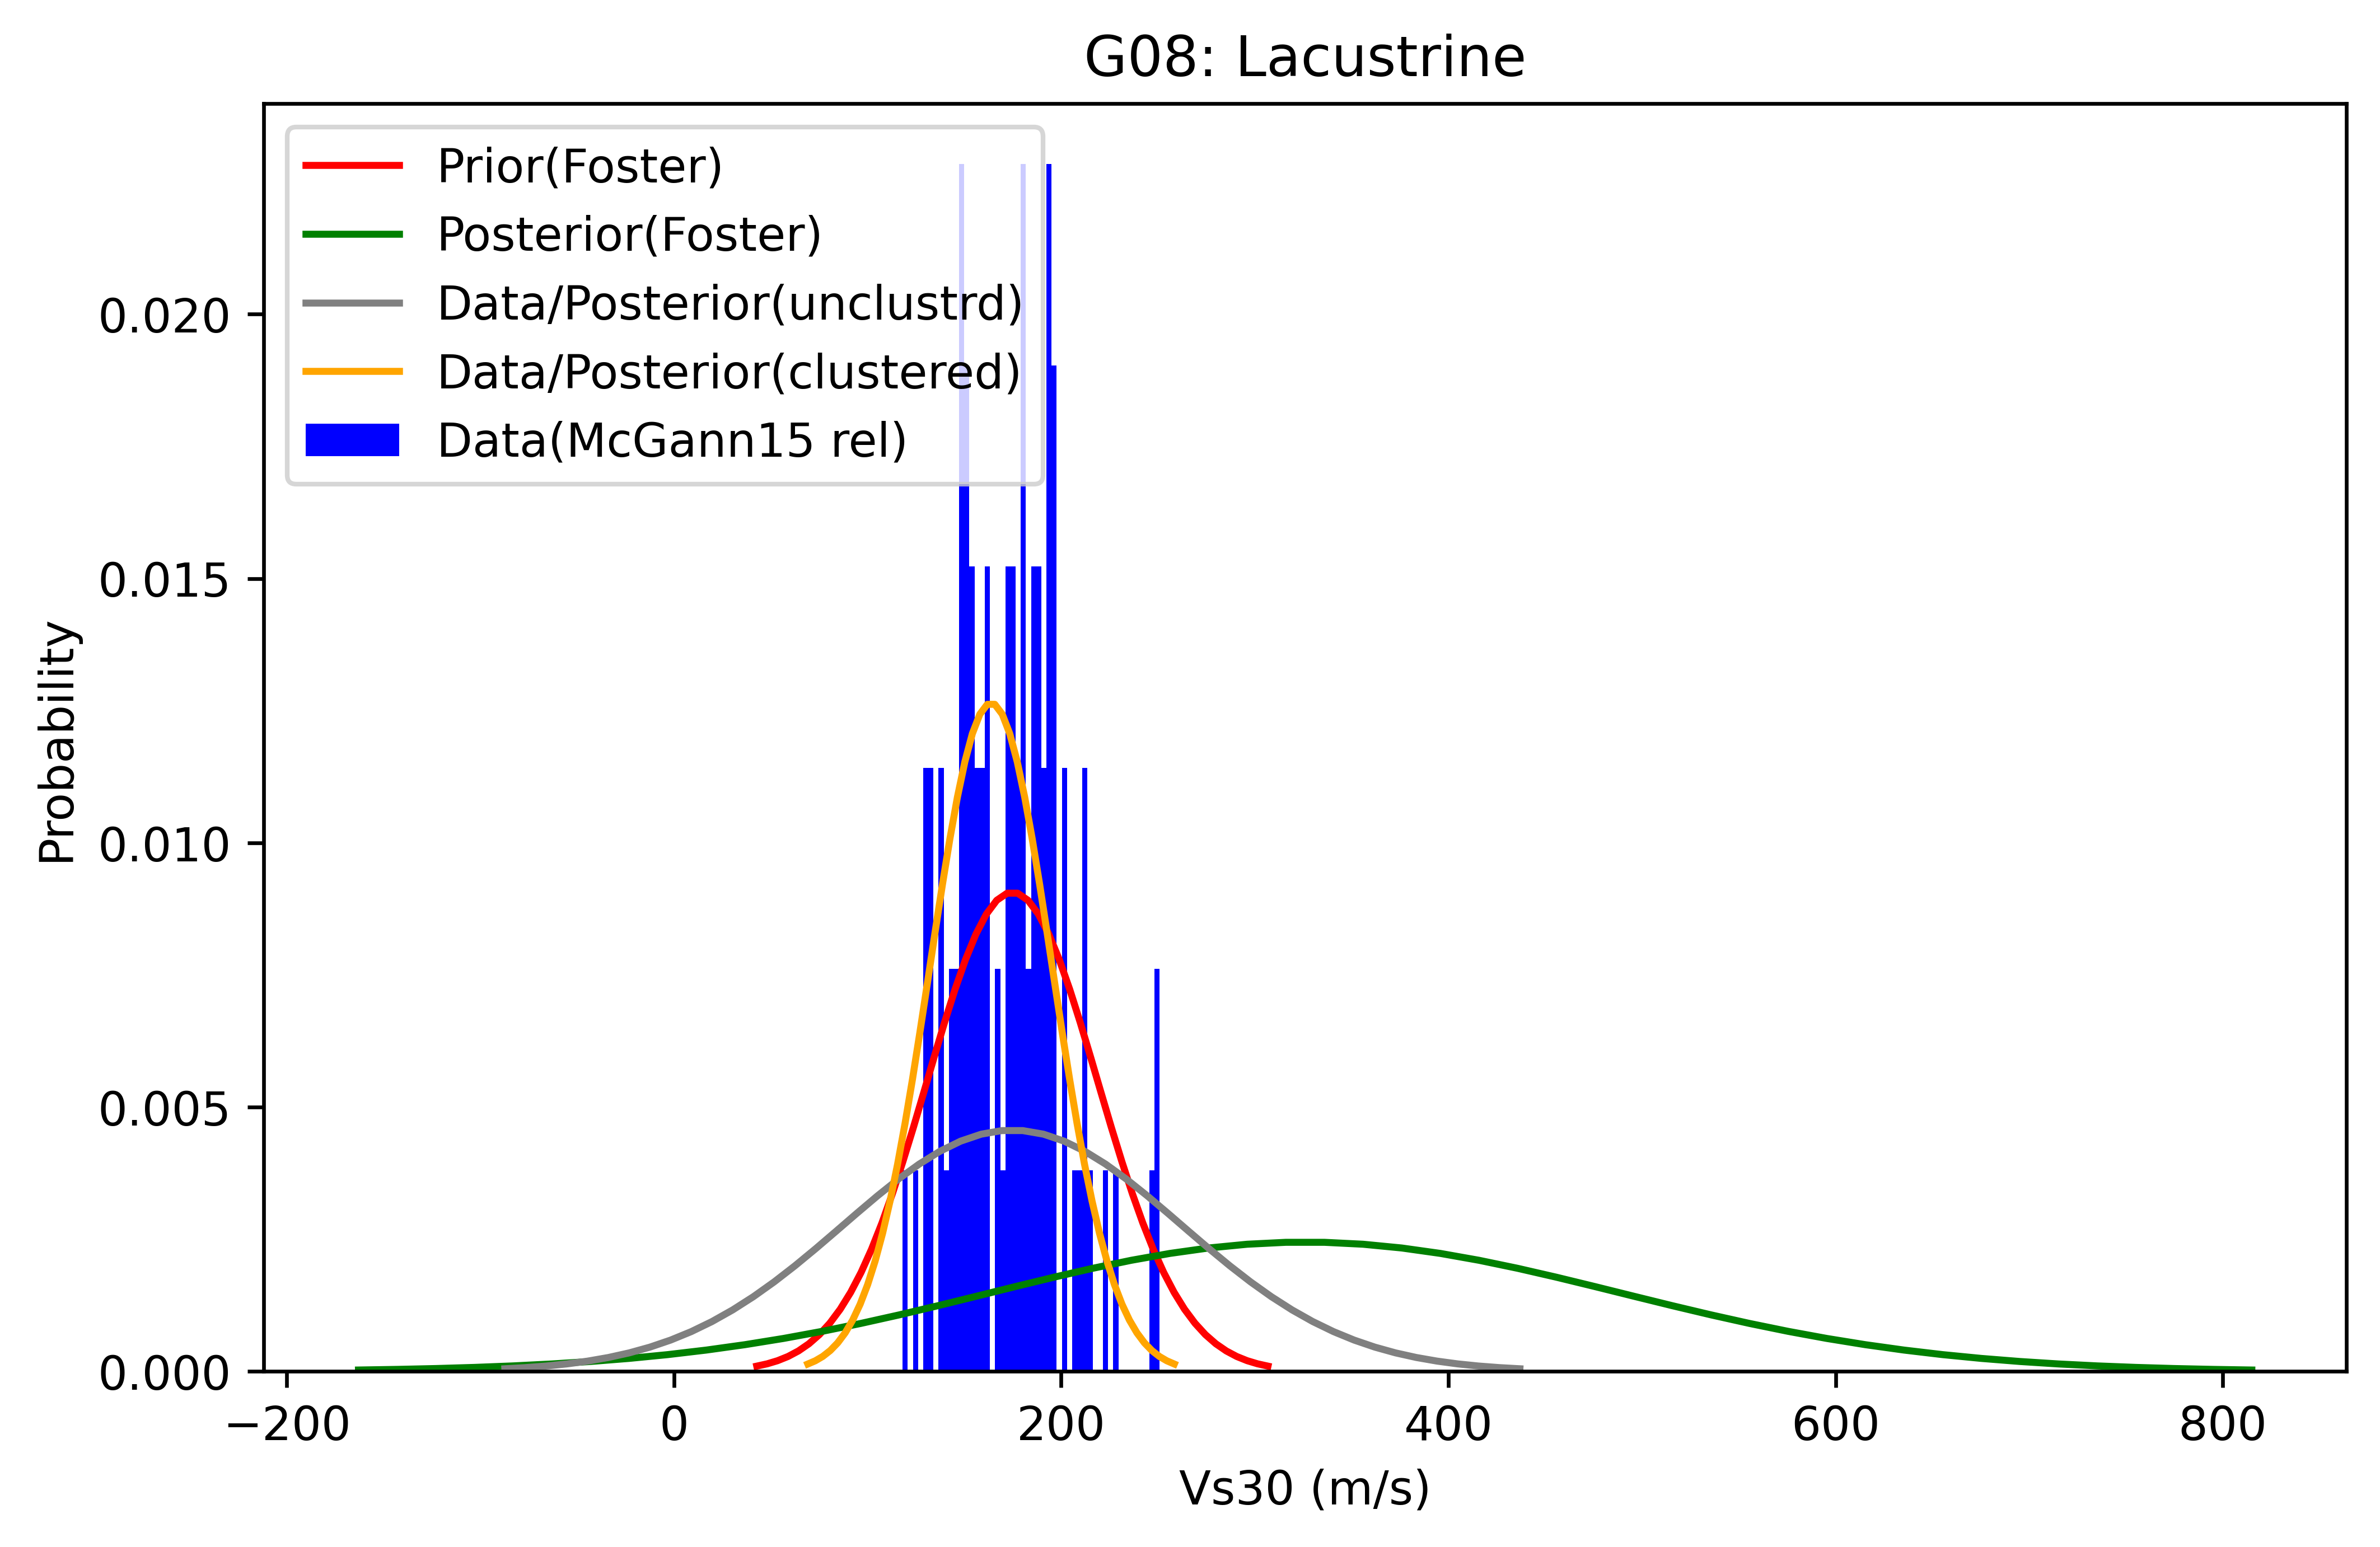

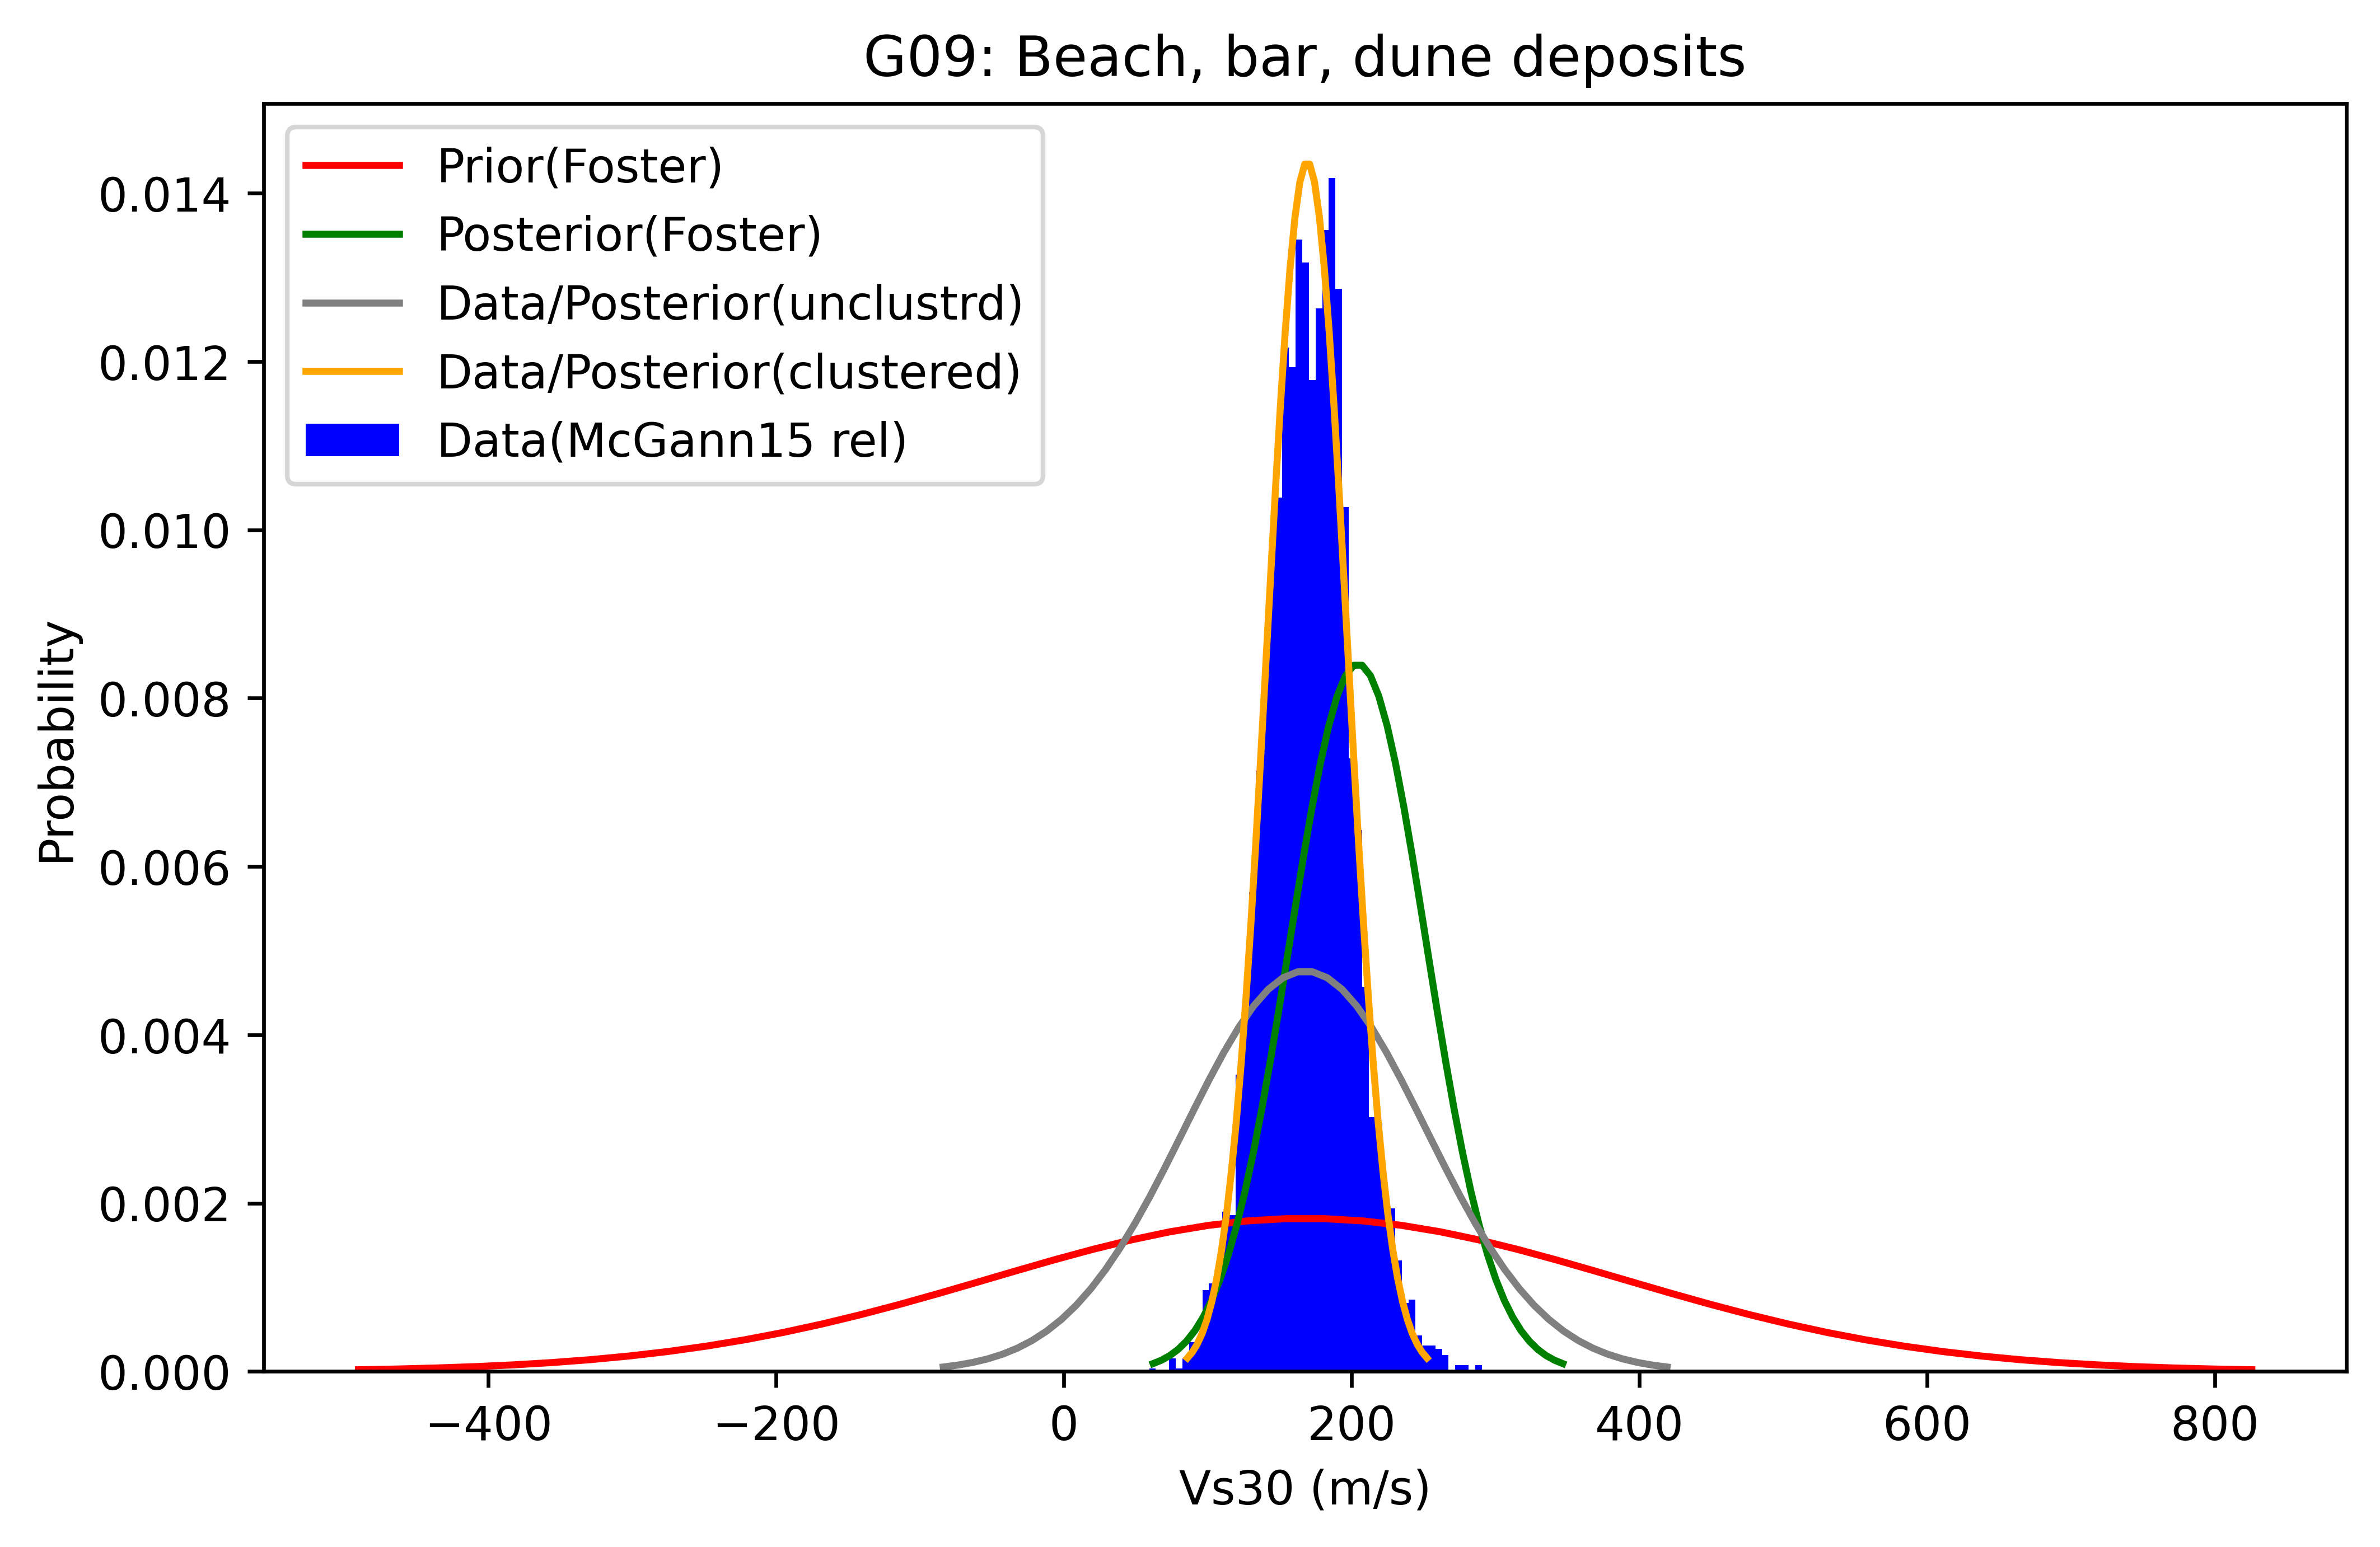

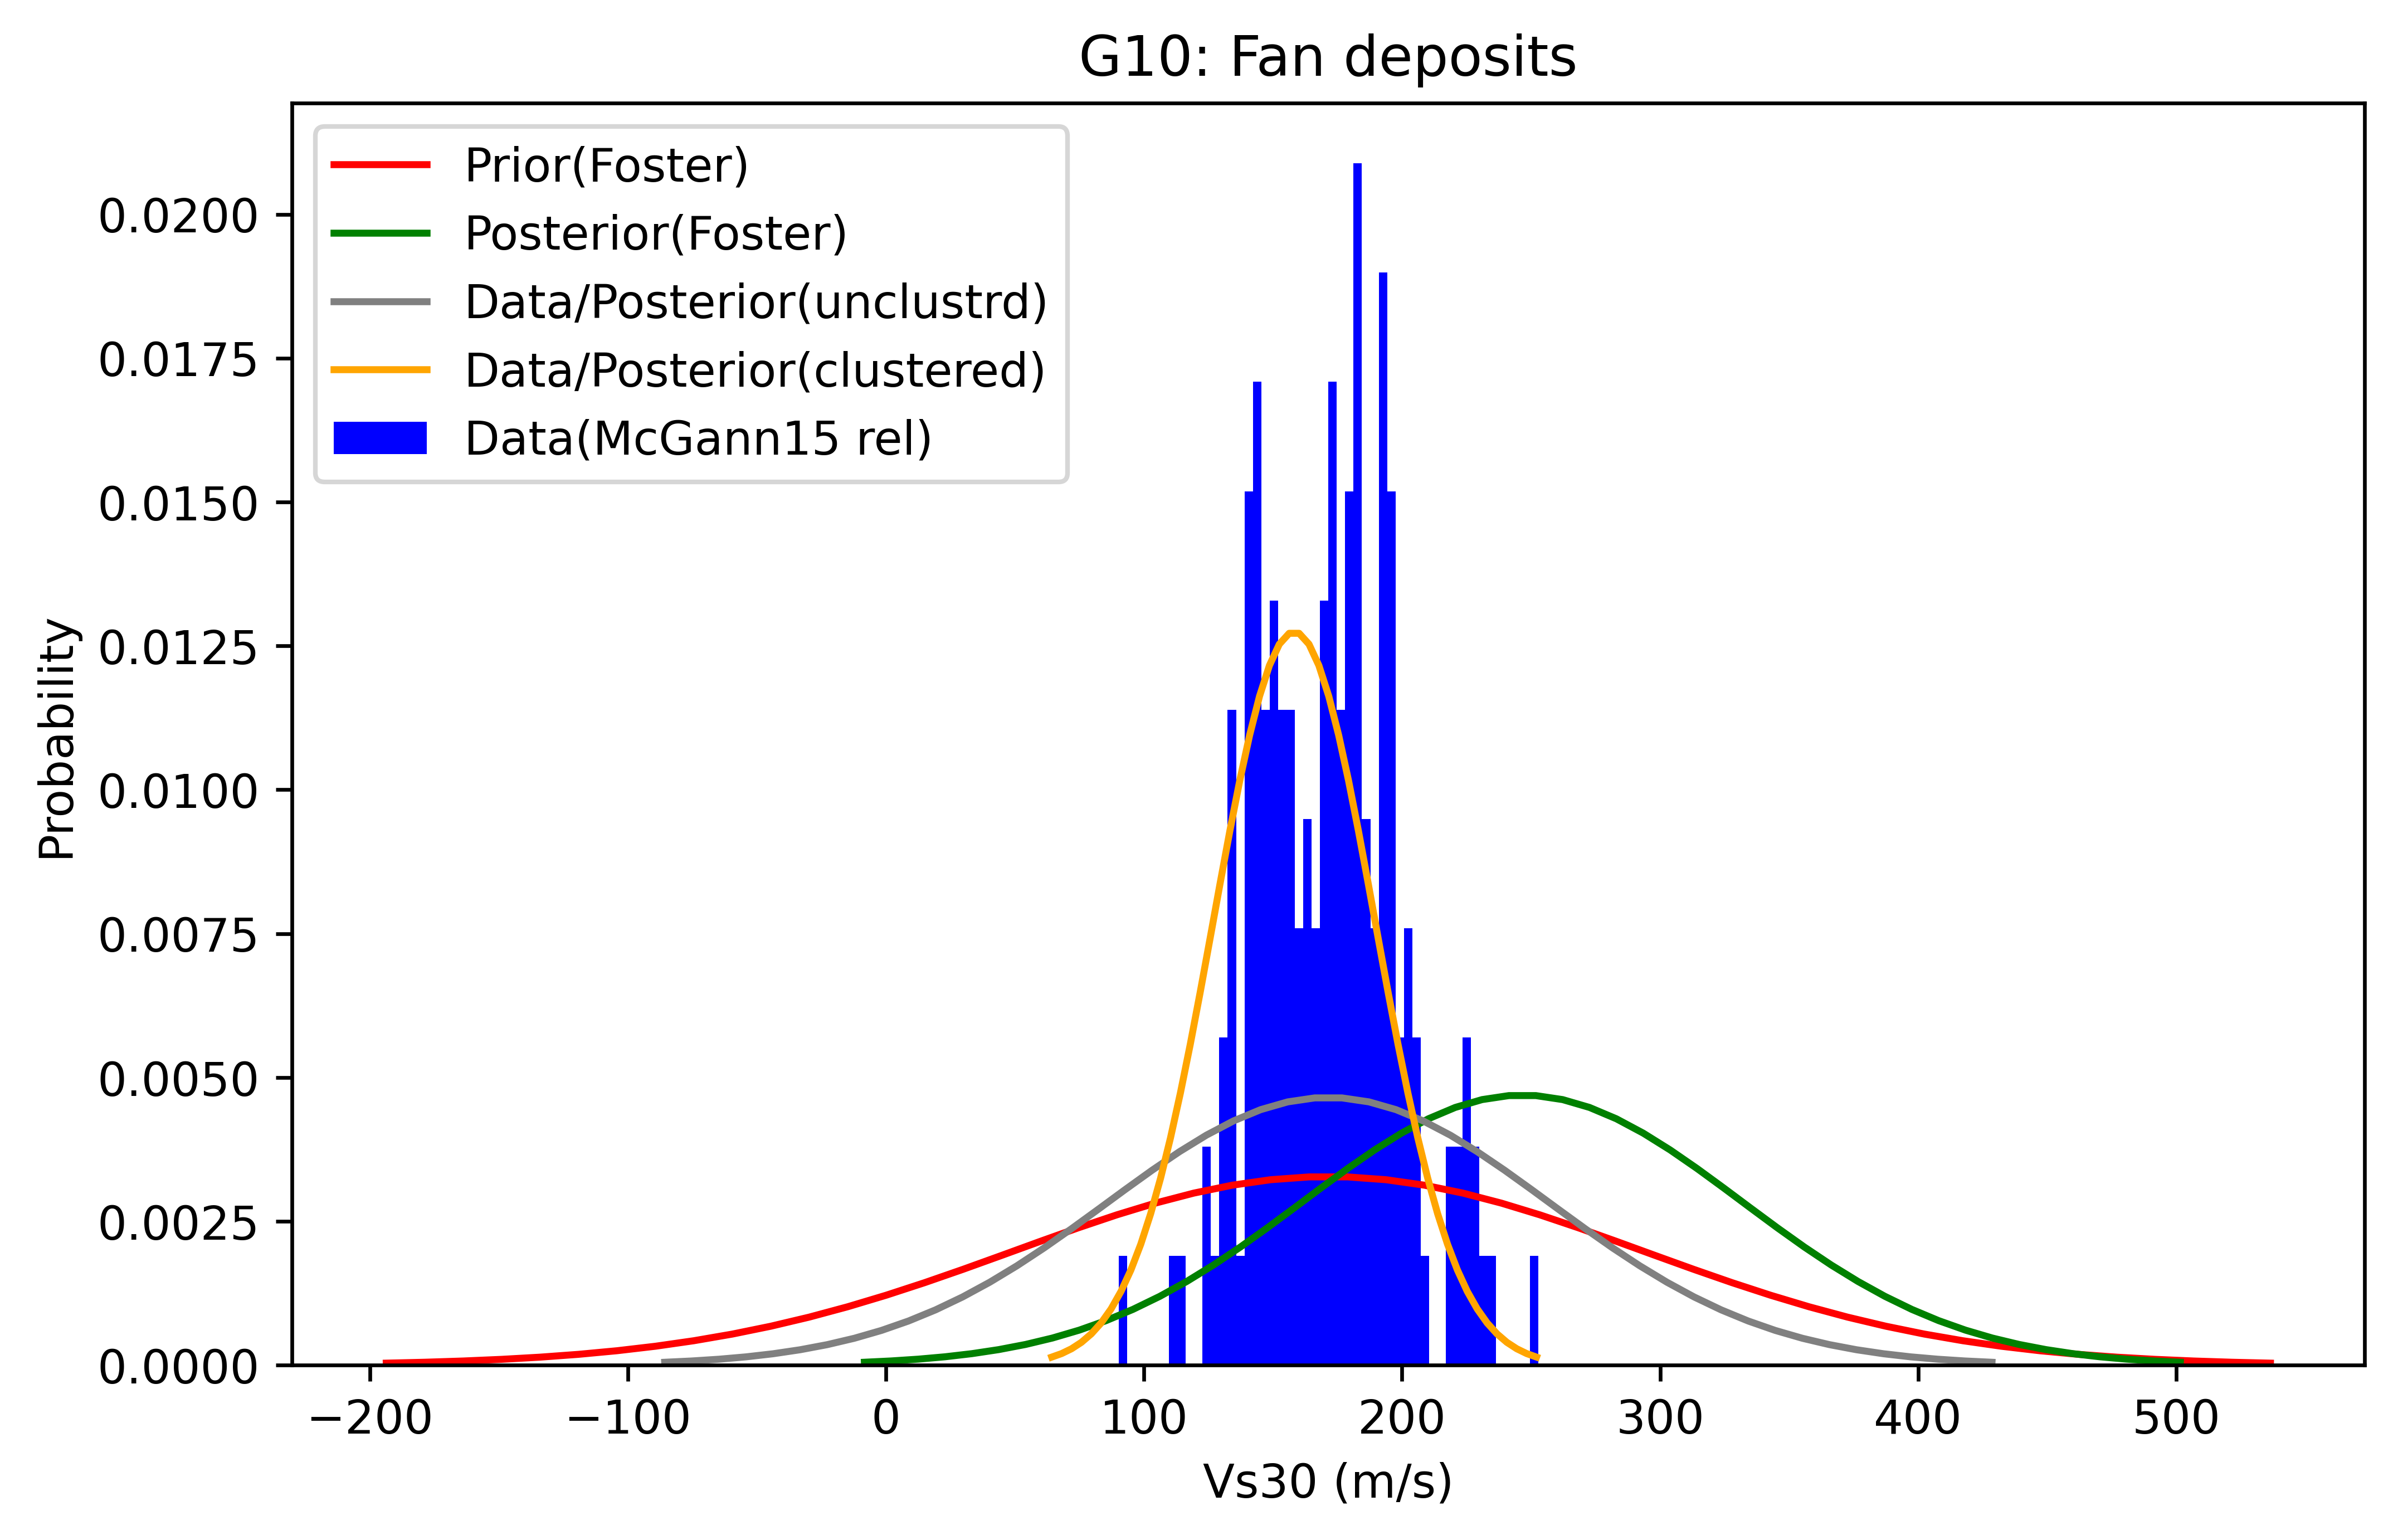

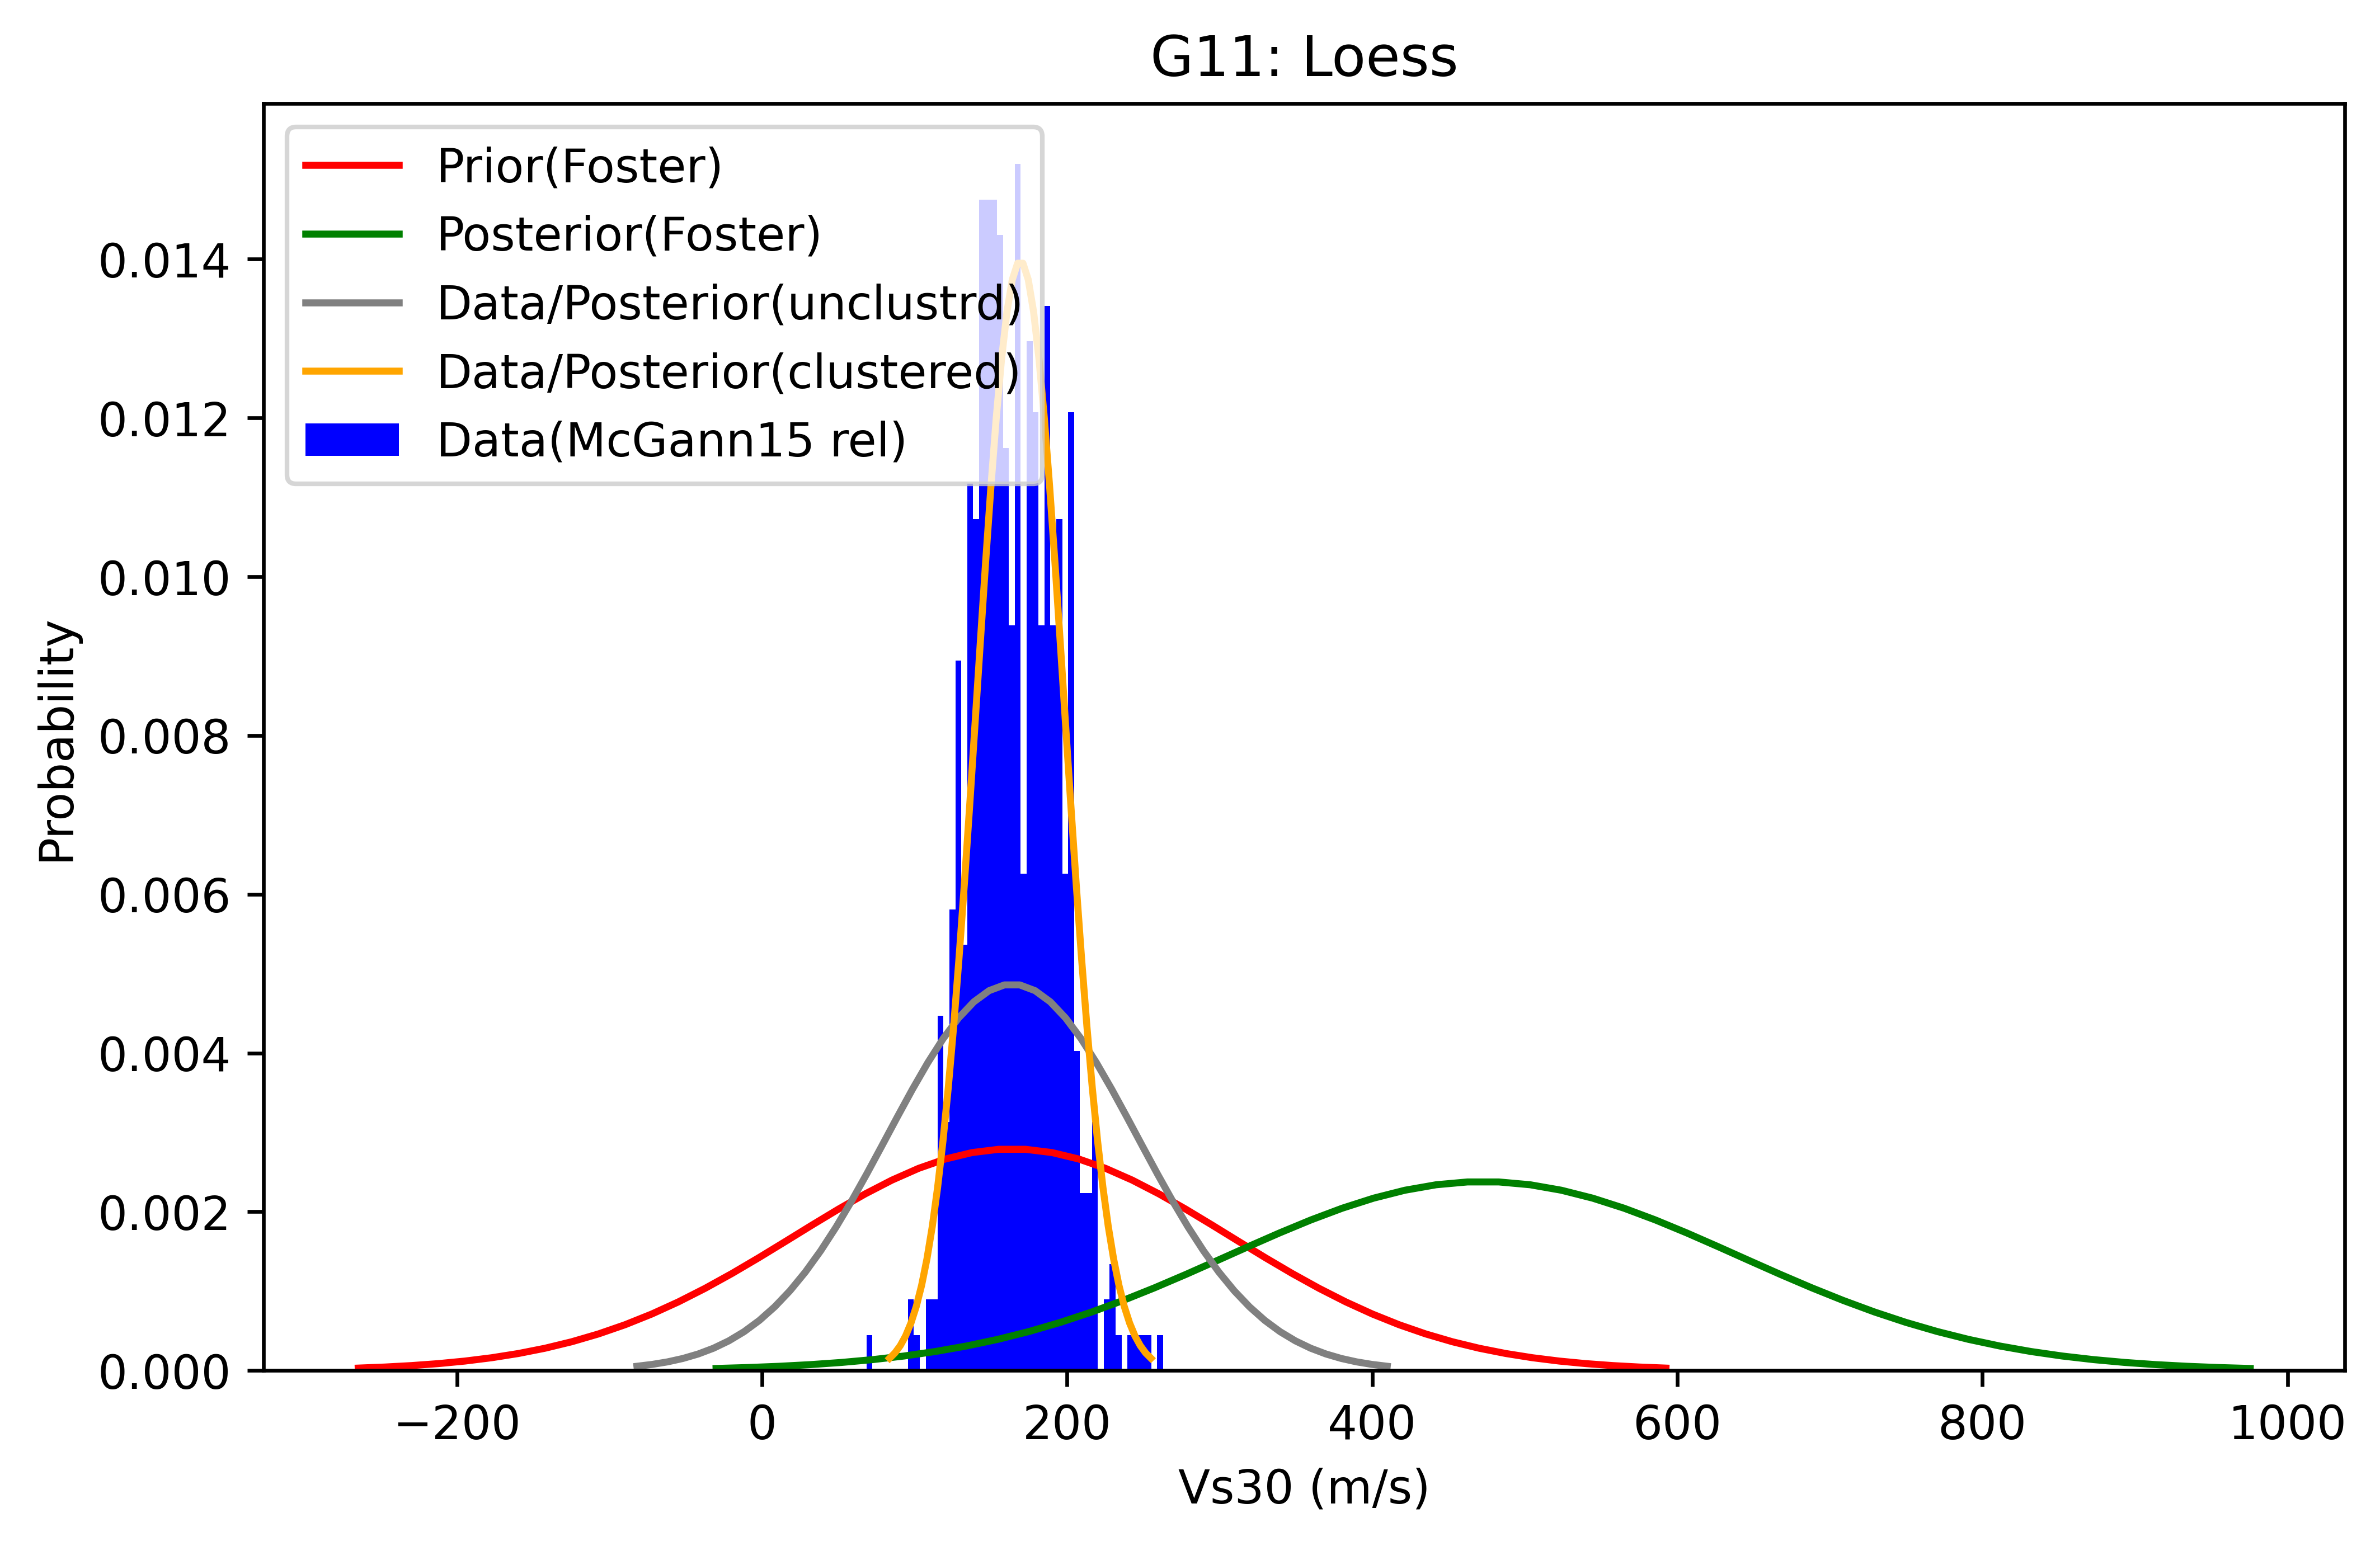

In [ ]:
data_dict = {
        "Prior(Foster)": [prior_means,prior_errors,'red'],
        "Posterior(Foster)": [posterior_means,posterior_errors,'green'],
        "Data/Posterior(unclustrd)": [new_posterior_means,new_posterior_errors,"gray"],
        "Data/Posterior(clustered)": [clustered_posterior_means,clustered_posterior_errors,"orange"]
}

for i in range(1,16):
    plot_hist_dist(data_dict,i)


In [ ]:
new_posterior_means=new_posterior.T[0]
new_posterior_errors=new_posterior.T[1]*new_posterior_means
clustered_posterior_means=clustered_posterior.T[0]
clustered_posterior_errors=clustered_posterior.T[1]*clustered_posterior_means

data_dict = {
    #"Prior(Foster)": [prior_means,prior_errors,'x','red'],
    "Posterior(Foster)": [posterior_means,posterior_errors,'o','green'],
    "Data(McGann15 rel)": [means,errors,"*","blue"],
    "Data/Posterior": [new_posterior_means,new_posterior_errors,"v","grey"],
    "Data/Posterior(Clustered)": [clustered_posterior_means,clustered_posterior_errors,"^","orange"]
}
plot_vs30_for_all_geo_ids(data_dict)